<a href="https://colab.research.google.com/github/fshnkarimi/Labeling/blob/main/Time_Series_Labelling_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import Libraries

In [38]:
# Import Libraries 
import itertools as itt
import numbers
import numpy as np
import pandas as pd
from abc import abstractmethod
from typing import Iterable, Tuple, List
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import xgboost as xgb
from prettytable import PrettyTable
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn import metrics
import seaborn as sns
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsRegressor

# Functions

In [39]:
# Labelling algorithm X is price and th is our threshould

def labeling(X, th):
    n = len(X)
    y = np.array([0 for i in range(n)])
    FP = X[0]
    xh = X[0]
    xl = X[0]
    HT = 0
    LT = 0
    cid = 0
    FP_N = 0
    for i in range(n):
        if(X[i] > FP + X[0]*th):
            xh, HT, FP_N, cid  = X[i], i, i, 1
            break
        if(X[i] < FP - X[0]*th):
            xh,HT,FP_N,cid  = X[i],i,i,-1
            break
    for i in range(FP_N+1,n):
        if(cid > 0):
            if(X[i]>xh):
                xh, HT = X[i], i
            if(X[i] < xh - xh * th and LT<= HT):
                for j in range(n):
                    if(j > LT and j <= HT):
                        y[j] = 1
                xl, LT, cid = X[i], i, -1
        if(cid < 0):
            if(X[i] < xl):
                xl, LT = X[i], i
            if(X[i] > xl + xl * th and HT <= LT):
                for j in range(n):
                    if(j > HT and j <= LT):
                        y[j] = 0
                xh, HT, cid = X[i], i, 1
    return y


In [40]:
# Implement Cross-validation methods

class BaseTimeSeriesCrossValidator:
    """
    Abstract class for time series cross-validation.
    Time series cross-validation requires each sample has a prediction time pred_time, at which the features are used to
    predict the response, and an evaluation time eval_time, at which the response is known and the error can be
    computed. Importantly, it means that unlike in standard sklearn cross-validation, the samples X, response y,
    pred_times and eval_times must all be pandas dataframe/series having the same index. It is also assumed that the
    samples are time-ordered with respect to the prediction time (i.e. pred_times is non-decreasing).
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    """
    def __init__(self, n_splits=10):
        if not isinstance(n_splits, numbers.Integral):
            raise ValueError(f"The number of folds must be of Integral type. {n_splits} of type {type(n_splits)}"
                             f" was passed.")
        n_splits = int(n_splits)
        if n_splits <= 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting n_splits = 2 "
                             f"or more, got n_splits = {n_splits}.")
        self.n_splits = n_splits
        self.pred_times = None
        self.eval_times = None
        self.indices = None

    @abstractmethod
    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series):
            raise ValueError('X should be a pandas DataFrame/Series.')
        if not isinstance(y, pd.Series) and y is not None:
            raise ValueError('y should be a pandas Series.')
        if not isinstance(pred_times, pd.Series):
            raise ValueError('pred_times should be a pandas Series.')
        if not isinstance(eval_times, pd.Series):
            raise ValueError('eval_times should be a pandas Series.')
        if y is not None and (X.index == y.index).sum() != len(y):
            raise ValueError('X and y must have the same index')
        if (X.index == pred_times.index).sum() != len(pred_times):
            raise ValueError('X and pred_times must have the same index')
        if (X.index == eval_times.index).sum() != len(eval_times):
            raise ValueError('X and eval_times must have the same index')

        self.pred_times = pred_times
        self.eval_times = eval_times
        self.indices = np.arange(X.shape[0])
        
class CombPurgedKFoldCV(BaseTimeSeriesCrossValidator):
    """
    Purged and embargoed combinatorial cross-validation
    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.
    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits folds are used as the test set, while the other folds are used as the train set.
    There are as many rounds as n_test_splits folds among the n_splits folds.
    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.) In addition, an "embargo" period is defined, giving the minimal time between an
    evaluation time in the test set and a prediction time in the training set. This is to avoid, in the presence of
    temporal correlation, a contamination of the test set by the train set.
    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.
    n_test_splits : int, default=2
        Number of folds used in the test set. Must be at least 1.
    embargo_td : pd.Timedelta, default=0
        Embargo period (see explanations above).
    """
    def __init__(self, n_splits=10, n_test_splits=2, embargo_td=0):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits > self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits

        if embargo_td < 0:
            raise ValueError(f"The embargo time should be positive, got embargo = {embargo_td}.")
        self.embargo_td = embargo_td

    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.
        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.
        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.
        y : pd.Series, not used, inherited from _BaseKFold
        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.
        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(self.indices, self.n_splits)]
        # List of all combinations of n_test_splits folds selected to become test sets
        selected_fold_bounds = list(itt.combinations(fold_bounds, self.n_test_splits))
        
        # In order for the first round to have its whole test set at the end of the dataset
        selected_fold_bounds.reverse()

        for fold_bound_list in selected_fold_bounds:
            # Computes the bounds of the test set, and the corresponding indices
            test_fold_bounds, test_indices = self.compute_test_set(fold_bound_list)
            # Computes the train set indices
            train_indices = self.compute_train_set(test_fold_bounds, test_indices)

            yield train_indices, test_indices

    def compute_train_set(self, test_fold_bounds: List[Tuple[int, int]], test_indices: np.ndarray) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.
        Parameters
        ----------
        test_fold_bounds : List of tuples of position indices
            Each tuple records the bounds of a block of indices in the test set.
        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.
        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.
        """
        # As a first approximation, the train set is the complement of the test set
        train_indices = np.setdiff1d(self.indices, test_indices)
        # But we now have to purge and embargo
        for test_fold_start, test_fold_end in test_fold_bounds:
            # Purge
            train_indices = purge(self, train_indices, test_fold_start, test_fold_end)
            # Embargo
            train_indices = embargo(self, train_indices, test_indices, test_fold_end)
        return train_indices

    def compute_test_set(self, fold_bound_list: List[Tuple[int, int]]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """
        Compute the indices of the samples in the test set.
        Parameters
        ----------
        fold_bound_list: List of tuples of position indices
            Each tuple records the bounds of the folds belonging to the test set.
        Returns
        -------
        test_fold_bounds: List of tuples of position indices
            Like fold_bound_list, but with the neighboring folds in the test set merged.
        test_indices: np.ndarray
            A numpy array containing the test indices.
        """
        test_indices = np.empty(0)
        test_fold_bounds = []
        for fold_start, fold_end in fold_bound_list:
            # Records the boundaries of the current test split
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            # If the current test split is contiguous to the previous one, simply updates the endpoint
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, self.indices[fold_start:fold_end]).astype(int)
        return test_fold_bounds, test_indices


def embargo(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
            test_indices: np.ndarray, test_fold_end: int) -> np.ndarray:
    """
    Apply the embargo procedure to part of the train set.
    This amounts to dropping the train set samples whose prediction time occurs within self.embargo_dt of the test
    set sample evaluation times. This method applies the embargo only to the part of the training set immediately
    following the end of the test set determined by test_fold_end.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times, cv.embargo_dt and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_indices : np.ndarray
        A numpy array containing all the indices of the samples in the test set.
    test_fold_end : int
        Index corresponding to the end of a test set block.
    Returns
    -------
    train_indices: np.ndarray
        The same array, with the indices subject to embargo removed.
    """
    if not hasattr(cv, 'embargo_td'):
        raise ValueError("The passed cross-validation object should have a member cv.embargo_td defining the embargo"
                         "time.")
    last_test_eval_time = cv.eval_times.iloc[cv.indices[:test_fold_end]].max()
    min_train_index = len(cv.pred_times[cv.pred_times <= last_test_eval_time + cv.embargo_td])
    if min_train_index < cv.indices.shape[0]:
        allowed_indices = np.concatenate((cv.indices[:test_fold_end], cv.indices[min_train_index:]))
        train_indices = np.intersect1d(train_indices, allowed_indices)
    return train_indices


def purge(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
          test_fold_start: int, test_fold_end: int) -> np.ndarray:
    """
    Purge part of the train set.
    Given a left boundary index test_fold_start of the test set, this method removes from the train set all the
    samples whose evaluation time is posterior to the prediction time of the first test sample after the boundary.
    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times and cv.indices.
    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.
    test_fold_start : int
        Index corresponding to the start of a test set block.
    test_fold_end : int
        Index corresponding to the end of the same test set block.
    Returns
    -------
    train_indices: np.ndarray
        A numpy array containing the train indices purged at test_fold_start.
    """
    time_test_fold_start = cv.pred_times.iloc[test_fold_start]
    # The train indices before the start of the test fold, purged.
    train_indices_1 = np.intersect1d(train_indices, cv.indices[cv.eval_times < time_test_fold_start])
    # The train indices after the end of the test fold.
    train_indices_2 = np.intersect1d(train_indices, cv.indices[test_fold_end:])

    return np.concatenate((train_indices_1, train_indices_2))

In [41]:
def get_metrics(label, y_pred, show_results=False):
  
  results = []
  results.append(metrics.accuracy_score(label, y_pred))
  results.append(metrics.precision_score(label, y_pred))
  results.append(metrics.recall_score(label, y_pred))
  results.append(metrics.f1_score(label, y_pred))

  if show_results:
    print("Accuracy:{:.6f}".format(metrics.accuracy_score(label, y_pred)))
    print("Precision:{:.6f}".format(metrics.precision_score(label, y_pred)))
    print("Recall:{:.6f}".format(metrics.recall_score(label, y_pred)))
    print("F1 score:{:.6f}".format(metrics.f1_score(label, y_pred)))
    
  return results

In [42]:
def data_pre1d(df, index, label, step_size):
  x = np.array([df[i + step_size - 1:i+step_size*11:step_size] for i in index if (i-1 + 11*step_size) in index])
  y = np.array([label[i-1 + 11*step_size] for i in index if (i-1 + 11*step_size) in index])
  x = x / np.mean(x,axis = 1).reshape((len(x), 1))
  x = x - np.ones((len(x), 1))
  x = x.reshape(x.shape[0], x.shape[1], 1)
  y = (y + 1) // 2
  return x, y

In [43]:
def denoise_data(df, col_name, k=100):
  clf = KNeighborsRegressor(n_neighbors=k, weights='uniform')
  clf.fit(df.index.values[:, np.newaxis], df["<CLOSE>"])
  y_pred = clf.predict(df.index.values[:, np.newaxis])  
  reverse_pred = y_pred[::-1]
  ax = pd.Series(df["<CLOSE>"]).plot(color='lightgray')
  pd.Series(y_pred).plot(color='black', ax=ax, figsize=(12, 8))
  plt.title("Denoising data")
  df['<CLOSE>'] = y_pred
  return df

In [44]:
def visualize(dfs, col_name, date, th, start, end):
  label = labeling(dfs[col_name], th)
  # date_col = dfs[date].astype(str).str[:4]
  date_col = dfs[date]
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=date_col[start:end], y=dfs[col_name][start:end]))
  fig.show()
  fig = go.Figure([go.Scatter(x=date_col[start:end], y=label[start:end])])
  fig.show() 

In [45]:
# Define a class for training models

class Train_data():
  def __init__(self, data,  train_start, train_end, test_end):
    self.train_start = train_start
    self.train_end = train_end
    self.test_end = test_end 
    self.data = data
    self.train_data = pd.Series(np.array(data[train_start:train_end]))
    self.train_label = None
    self.test_data = pd.Series(np.array(data[train_end:test_end]))
    self.test_label = None
    self.splits = []
    self.X_train  = []
    self.y_train = []
    self.X_test  = []
    self.y_test = []
    self.GRU_beta_result = None
    self.LSTM_beta_result = None
    self.XGboost_beta_result = None
    self.SVM_beta_result = None
    self.Logreg_beta_result = None
    self.GRU_result = None
    self.LSTM_result = None
    self.XGboost_result = None
    self.SVM_result = None
    self.Logreg_result = None
    self.GRU_beta_predict = None
    self.LSTM_beta_predict = None
    self.XGboost_beta_predict = None
    self.SVM_beta_predict = None
    self.Logreg_beta_predict = None
    self.GRU_predict = None
    self.LSTM_predict = None
    self.XGboost_predict = None
    self.SVM_predict = None
    self.Logreg_predict = None

  def set_threshold(self, th):
    label  = labeling(self.data, th)
    self.train_label = pd.Series(np.array(label[self.train_start:self.train_end]))
    self.test_label = pd.Series(np.array(label[self.train_end:self.test_end]))

  def K_fold_purged(self, num_split, num_test, time_gaps, emb=0, purging=True):
    n_splits = num_split
    n_test_splits = num_test
    time_gap = time_gaps
    embargo_td = emb
    t1_ = self.train_data.index
    t1 = pd.Series(t1_).shift(time_gap).fillna(0).astype(int)
    t2 = pd.Series(t1_).shift(-time_gap).fillna(1e12).astype(int)
    
    if purging:
      cpkf = CombPurgedKFoldCV(n_splits=n_splits, n_test_splits=n_test_splits, embargo_td=embargo_td)
      comb_purged_splits = list(cpkf.split(self.train_data, pred_times=t1, eval_times=t2))
      self.splits = comb_purged_splits
    
    else:
      cvts = TimeSeriesSplit(n_splits=n_splits)
      cvts_splits = list(cvts.split(self.train_data))
      self.splits = cvts_splits


  def SVM(self, beta):

    Xtrain = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1])
    clf = SVC(C=1)
    clf.fit( Xtrain,self.y_train)
    y_pred = clf.predict(Xtest)
    if beta : 
      self.SVM_beta_result  =  get_metrics(self.y_test, y_pred,0)
      self.SVM_beta_predict = y_pred    
    else:
      self.SVM_result  =  get_metrics(self.y_test,y_pred,0)
      self.SVM_predict = y_pred
    

  def log_reg(self, beta):
    
    Xtrain = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1])
    clf = LogisticRegression(C=10, penalty="l2")
    clf.fit( Xtrain,self.y_train)
    y_pred = clf.predict(Xtest)
    if beta: 
      self.Logreg_beta_result  =  get_metrics(self.y_test,y_pred,0)
      self.Logreg_beta_predict = y_pred
    else:
      self.Logreg_result  =  get_metrics(self.y_test,y_pred,0)
      self.Logreg_predict = y_pred
    
    

  def data_preprocess(self, step_size):  
    self.X_train, self.y_train = data_pre1d(self.train_data, self.train_data.index, self.train_label,step_size)
    self.X_test, self.y_test = data_pre1d(self.test_data, self.test_data.index, self.test_label,step_size)
    

  def LSTM(self, epoch, layer_size, window_size, lr, beta):
    with tf.device('/device:GPU:0'):
      model=Sequential()
      model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.compat.v1.keras.layers.CuDNNLSTM(layer_size))
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
      
      if beta:
        print(f'start lstm beta training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test, self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.LSTM_beta_result = get_metrics(self.y_test, y_pred, False)
        self.LSTM_beta_predict = y_pred
      else:
        print(f'start lstm training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test, self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.LSTM_result = get_metrics(self.y_test, y_pred, False)
        self.LSTM_predict = y_pred
      
      print('end training. \n')

  def GRU(self, epoch, layer_size, window_size, lr, beta):
    with tf.device('/device:GPU:0'):
      model=Sequential()
      model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size,return_sequences=True,input_shape=(window_size,1)))
      model.add(Dropout(0.4))
      model.add(tf.compat.v1.keras.layers.CuDNNGRU(layer_size))
      model.add(Dropout(0.4))
      model.add(Dense(1, activation='sigmoid'))
      opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      if beta:
        print('start gru beta training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.GRU_beta_result = get_metrics(self.y_test,y_pred,False)
        self.GRU_beta_predict = y_pred
      else:
        print('start gru training...\n')
        model.fit(self.X_train,self.y_train,validation_data=(self.X_test,self.y_test),epochs=epoch,batch_size=16,verbose=1)
        y_pred = model.predict(self.X_test)
        y_pred = np.array([1 if y >=0.5 else 0 for y in y_pred])
        self.GRU_result = get_metrics(self.y_test,y_pred,False)
        self.GRU_predict = y_pred

      print('end training. \n')

  def XGboost(self,es,beta):
    Xtrain = self.X_train.reshape(self.X_train.shape[0],self.X_train.shape[1])
    Xtest = self.X_test.reshape(self.X_test.shape[0],self.X_test.shape[1])
    # XGBoost classifier with Early-stopping
    clf = xgb.XGBClassifier(n_jobs=1)
    if beta:
      print('start xgboost beta training...\n')
      clf.fit(Xtrain, self.y_train, early_stopping_rounds=es, eval_metric="auc",eval_set=[(Xtest, self.y_test)])
      y_pred = clf.predict(Xtest)
      self.XGboost_beta_result = get_metrics(self.y_test,y_pred,False)
      self.XGboost_beta_predict = y_pred
    else:
      print('start xgboost training...\n')
      clf.fit(Xtrain, self.y_train, early_stopping_rounds=es, eval_metric="auc",eval_set=[(Xtest, self.y_test)])
      y_pred = clf.predict(Xtest)
      self.XGboost_result = get_metrics(self.y_test,y_pred,False)
      self.XGboost_predict = y_pred

    print('end training. \n')


  def table(self, th = 0.1):
    x = PrettyTable()
    x.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1 score"]
    self.LSTM_result.insert(0,"LSTM "+str(th))
    self.GRU_result.insert(0,"GRU "+str(th))
    self.XGboost_result.insert(0,"XGBoost "+str(th))
    self.Logreg_result.insert(0,"Logreg "+str(th))
    self.SVM_result.insert(0,"SVM "+str(th))
    self.LSTM_beta_result.insert(0,"LSTM beta "+str(th))
    self.GRU_beta_result.insert(0,"GRU beta "+str(th))
    self.XGboost_beta_result.insert(0,"XGBoost beta "+str(th))
    self.Logreg_beta_result.insert(0,"logreg beta "+str(th))
    self.SVM_beta_result.insert(0,"svm beta "+str(th))
    x.add_row(self.LSTM_result)
    x.add_row(self.GRU_result)
    x.add_row(self.XGboost_result)
    x.add_row(self.Logreg_result)
    x.add_row(self.SVM_result)
    x.add_row(self.LSTM_beta_result)
    x.add_row(self.GRU_beta_result)
    x.add_row(self.XGboost_beta_result)
    x.add_row(self.Logreg_beta_result)
    x.add_row(self.SVM_beta_result)
    return x


  
  def train_models(self, best_parameters, step_sizes=4, th = 0.1):

    lstm_epoch = best_parameters[0]
    lstm_layer = best_parameters[1]
    lstm_lr = best_parameters[2]
    gru_epoch = best_parameters[3]
    gru_layer = best_parameters[4]
    gru_lr = best_parameters[5]

    self.data_preprocess(step_size=1)
    self.LSTM(lstm_epoch, lstm_layer, 11, lstm_lr, False)
    self.GRU(gru_epoch, gru_layer, 11, gru_lr, False)
    self.XGboost(50, False)
    self.SVM(False)
    self.log_reg(False)

    self.data_preprocess(step_size=step_sizes)
    self.LSTM(lstm_epoch,lstm_layer,11,lstm_lr,True)
    self.GRU(gru_epoch,gru_layer,11,gru_lr,True)
    self.XGboost(50,True)
    self.SVM(True)
    self.log_reg(True)

    print(self.table(th = th))


In [46]:
# Default best parameters

default_best_param = [5, 10, 0.01, 5, 10, 0.01]

def final_result(historical, name, best_param=default_best_param, step_sizes=4, th=0.1):
  historical.train_models(best_param, step_sizes, th=th)
  results = []
  results.append(historical.LSTM_result)
  results.append(historical.GRU_result)
  results.append(historical.XGboost_result)
  results.append(historical.Logreg_result)
  results.append(historical.SVM_result)
  results.append(historical.LSTM_beta_result)
  results.append(historical.GRU_beta_result)
  results.append(historical.XGboost_beta_result)
  results.append(historical.Logreg_beta_result)
  results.append(historical.SVM_beta_result)
  res = pd.DataFrame()
  
  for x in results:
    dic = {
      "Name": name,
      "Model": x[0],
      "acc": x[1],
      "Perc": x[2], 
      "recal": x[3], 
      "f1" :x[4]

    }
    res = res.append(dic, ignore_index=True)
  return res

# Results

## AMD

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>    <LOW>    <CLOSE>     <VOL>
0     US1.AMD     D  20101004       0  ...    7.08    6.840   7.868584  22229263
1     US1.AMD     D  20101005       0  ...    7.12    6.890   7.868584  34185258
2     US1.AMD     D  20101006       0  ...    7.05    6.780   7.868584  23076122
3     US1.AMD     D  20101007       0  ...    6.93    6.770   7.868584  20010148
4     US1.AMD     D  20101008       0  ...    7.10    6.790   7.868584  24895450
...       ...   ...       ...     ...  ...     ...      ...        ...       ...
2764  US1.AMD     D  20210927       0  ...  108.43  103.440  94.725300   1337149
2765  US1.AMD     D  20210928       0  ...  107.63  101.425  94.725300   1661005
2766  US1.AMD     D  20210929       0  ...  102.64   99.820  94.725300   1241696
2767  US1.AMD     D  20210930       0  ...  104.43  102.070  94.725300   1313306
2768  US1.AMD     D  20211001       0  ...  102.97  100.670  94.725300   1095599

[2769 rows x 9 columns]

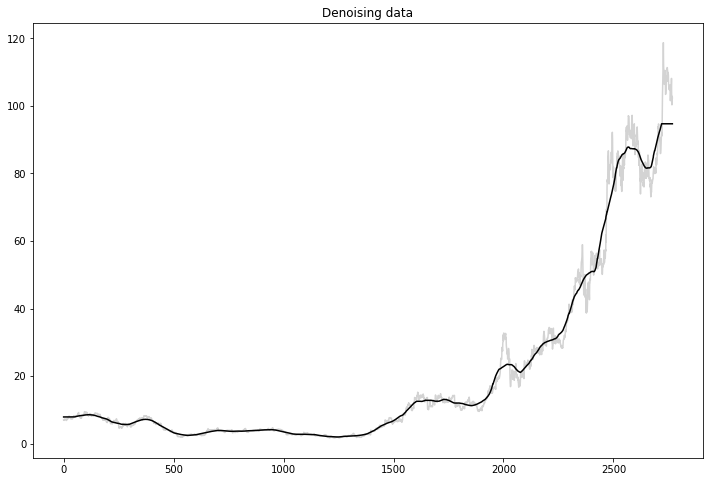

In [47]:
dfs = pd.read_csv("AMD.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [48]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [49]:
col_name = '<CLOSE>'
threshholds = [.1, .05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "AMD", step_sizes=4, th= th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6855 - accuracy: 0.5592 - val_loss: 0.7558 - val_accuracy: 0.3347
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.4064 - accuracy: 0.8237 - val_loss: 1.2473 - val_accuracy: 0.5122
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3196 - accuracy: 0.8373 - val_loss: 2.1439 - val_accuracy: 0.4286
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2885 - accuracy: 0.8734 - val_loss: 2.4517 - val_accuracy: 0.4898
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3007 - accuracy: 0.8686 - val_loss: 1.7095 - val_accuracy: 0.4980
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6002 - accuracy: 0.6467 - val_loss: 1.2465 - val_accuracy: 0.5265
Epoch 2/5
106/106 [==============================] - 1s 10ms/step -

In [50]:
Result_cross.to_csv('AMD_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0           LSTM 0.1  AMD  0.398010  0.497959  0.565371  0.975610
1            GRU 0.1  AMD  0.415789  0.534694  0.580882  0.963415
2        XGBoost 0.1  AMD  0.396088  0.491837  0.565445  0.987805
3         Logreg 0.1  AMD  0.397531  0.495918  0.565905  0.981707
4            SVM 0.1  AMD  0.402985  0.506122  0.572438  0.987805
5      LSTM beta 0.1  AMD  0.384817  0.448578  0.538462  0.896341
6       GRU beta 0.1  AMD  0.395466  0.459519  0.559715  0.957317
7   XGBoost beta 0.1  AMD  0.389163  0.444201  0.554386  0.963415
8    logreg beta 0.1  AMD  0.391414  0.452954  0.553571  0.945122
9       svm beta 0.1  AMD  0.395000  0.457330  0.560284  0.963415
0          LSTM 0.05  AMD  0.986807  0.963265  0.976501  0.966408
1           GRU 0.05  AMD  0.945274  0.940816  0.963245  0.981912
2       XGBoost 0.05  AMD  0.962217  0.959184  0.974490  0.987080
3        Logreg 0.05  AMD  0.964286  0.953061  0.970475  0.976744
4           SVM 0.05  AMD  0.962121  0.957143  0.973180  0.984496
5     LSTM beta 0.05  AMD  0.924623  0.892779  0.937580  0.950904
6      GRU beta 0.05  AMD  0.935802  0.925602  0.957071  0.979328
7  XGBoost beta 0.05  AMD  0.954082  0.932166  0.960205  0.966408
8   logreg beta 0.05  AMD  0.933333  0.892779  0.936937  0.940568
9      svm beta 0.05  AMD  0.939394  0.914661  0.950192  0.961240

In [51]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_logreg_beta.csv')

###Purging

In [52]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "AMD", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6659 - accuracy: 0.5929 - val_loss: 0.7356 - val_accuracy: 0.3347
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6881 - accuracy: 0.5538 - val_loss: 0.7146 - val_accuracy: 0.3347
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5903 - accuracy: 0.7047 - val_loss: 0.6538 - val_accuracy: 0.6653
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6862 - accuracy: 0.5544 - val_loss: 0.7449 - val_accuracy: 0.3347
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6768 - accuracy: 0.5734 - val_loss: 0.8766 - val_accuracy: 0.3347
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 12ms/step - loss: 0.6370 - accuracy: 0.6095 - val_loss: 1.8812 - val_accuracy: 0.4245
Epoch 2/5
106/106 [==============================] - 1s 10ms/step -

In [53]:
Result_purging.to_csv('AMD_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0           LSTM 0.1  AMD  0.334694  0.334694  0.501529  1.000000
1            GRU 0.1  AMD  0.395122  0.489796  0.564460  0.987805
2        XGBoost 0.1  AMD  0.396088  0.491837  0.565445  0.987805
3         Logreg 0.1  AMD  0.397531  0.495918  0.565905  0.981707
4            SVM 0.1  AMD  0.402985  0.506122  0.572438  0.987805
5      LSTM beta 0.1  AMD  0.390977  0.450766  0.554174  0.951220
6       GRU beta 0.1  AMD  0.395990  0.459519  0.561279  0.963415
7   XGBoost beta 0.1  AMD  0.389163  0.444201  0.554386  0.963415
8    logreg beta 0.1  AMD  0.391414  0.452954  0.553571  0.945122
9       svm beta 0.1  AMD  0.395000  0.457330  0.560284  0.963415
0          LSTM 0.05  AMD  0.986807  0.963265  0.976501  0.966408
1           GRU 0.05  AMD  0.961929  0.953061  0.970551  0.979328
2       XGBoost 0.05  AMD  0.962217  0.959184  0.974490  0.987080
3        Logreg 0.05  AMD  0.964286  0.953061  0.970475  0.976744
4           SVM 0.05  AMD  0.962121  0.957143  0.973180  0.984496
5     LSTM beta 0.05  AMD  0.926582  0.890591  0.936061  0.945736
6      GRU beta 0.05  AMD  0.958333  0.923414  0.954604  0.950904
7  XGBoost beta 0.05  AMD  0.954082  0.932166  0.960205  0.966408
8   logreg beta 0.05  AMD  0.933333  0.892779  0.936937  0.940568
9      svm beta 0.05  AMD  0.939394  0.914661  0.950192  0.961240

In [54]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMD_logreg_beta_p.csv')

## AAPL

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>     <LOW>    <CLOSE>     <VOL>
0     US1.AAPL     D  20101004       0  ...  282.90  277.7700  323.93085  14964464
1     US1.AAPL     D  20101005       0  ...  289.44  281.8205  323.93085  16379352
2     US1.AAPL     D  20101006       0  ...  291.99  285.2600  323.93085  22791119
3     US1.AAPL     D  20101007       0  ...  290.48  286.9100  323.93085  13965617
4     US1.AAPL     D  20101008       0  ...  294.50  290.0000  323.93085  21492761
...        ...   ...       ...     ...  ...     ...       ...        ...       ...
2762  US1.AAPL     D  20210927       0  ...  145.96  143.8300  140.59160   3504880
2763  US1.AAPL     D  20210928       0  ...  144.75  141.7000  140.59160   5602142
2764  US1.AAPL     D  20210929       0  ...  144.45  142.0300  140.59160   3205269
2765  US1.AAPL     D  20210930       0  ...  144.37  141.2900  140.59160   4102531
2766  US1.AAPL     D  20211001       0  ...  142.91  139.1300  140.59160   4233615

[2767 rows x 9 columns]

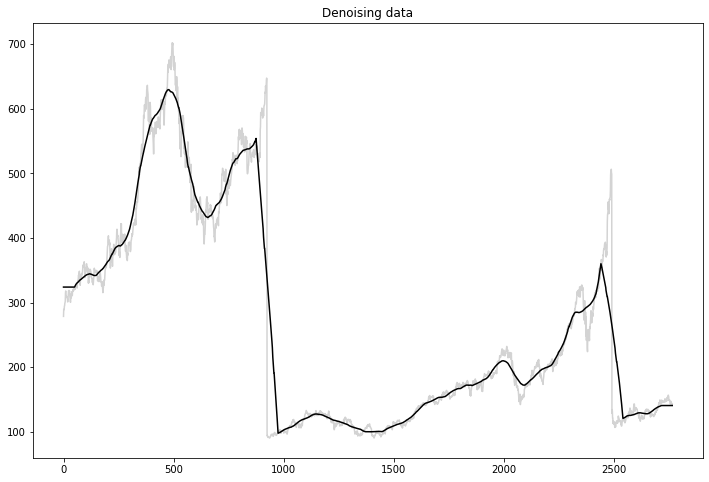

In [ ]:
dfs = pd.read_csv("AAPL.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 100, 2300)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05, .1, .15]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "AAPL", step_sizes=4, th= th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.6278 - accuracy: 0.6882 - val_loss: 0.5262 - val_accuracy: 0.8082
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6229 - accuracy: 0.6899 - val_loss: 0.5486 - val_accuracy: 0.8082
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5623 - accuracy: 0.7580 - val_loss: 0.5116 - val_accuracy: 0.8082
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5815 - accuracy: 0.7379 - val_loss: 0.5112 - val_accuracy: 0.8082
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3578 - accuracy: 0.8669 - val_loss: 0.1145 - val_accuracy: 0.9490
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6260 - accuracy: 0.6846 - val_loss: 0.5090 - val_accuracy: 0.8082
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [ ]:
Result_cross.to_csv('AAPL_Result_cross.csv')
Result_cross

Model  Name      Perc       acc        f1     recal
0          LSTM 0.05  AAPL  0.984334  0.948980  0.967908  0.952020
1           GRU 0.05  AAPL  0.987374  0.979592  0.987374  0.987374
2       XGBoost 0.05  AAPL  0.994872  0.979592  0.987277  0.979798
3        Logreg 0.05  AAPL  0.912442  0.922449  0.954217  1.000000
4           SVM 0.05  AAPL  0.984848  0.975510  0.984848  0.984848
5     LSTM beta 0.05  AAPL  0.934426  0.901532  0.938272  0.942149
6      GRU beta 0.05  AAPL  0.976879  0.927790  0.953456  0.931129
7  XGBoost beta 0.05  AAPL  0.991329  0.949672  0.967560  0.944904
8   logreg beta 0.05  AAPL  0.935567  0.945295  0.966711  1.000000
9      svm beta 0.05  AAPL  0.953930  0.938731  0.961749  0.969697
0           LSTM 0.1  AAPL  0.956416  0.961224  0.976514  0.997475
1            GRU 0.1  AAPL  0.984810  0.973469  0.983565  0.982323
2        XGBoost 0.1  AAPL  0.994872  0.979592  0.987277  0.979798
3         Logreg 0.1  AAPL  0.912442  0.922449  0.954217  1.000000
4            SVM 0.1  AAPL  0.984848  0.975510  0.984848  0.984848
5      LSTM beta 0.1  AAPL  0.929730  0.901532  0.938608  0.947658
6       GRU beta 0.1  AAPL  0.966759  0.943107  0.964088  0.961433
7   XGBoost beta 0.1  AAPL  0.991329  0.949672  0.967560  0.944904
8    logreg beta 0.1  AAPL  0.935567  0.945295  0.966711  1.000000
9       svm beta 0.1  AAPL  0.953930  0.938731  0.961749  0.969697
0          LSTM 0.15  AAPL  0.982234  0.967347  0.979747  0.977273
1           GRU 0.15  AAPL  0.987212  0.969388  0.980940  0.974747
2       XGBoost 0.15  AAPL  0.994872  0.979592  0.987277  0.979798
3        Logreg 0.15  AAPL  0.912442  0.922449  0.954217  1.000000
4           SVM 0.15  AAPL  0.984848  0.975510  0.984848  0.984848
5     LSTM beta 0.15  AAPL  0.937500  0.910284  0.943912  0.950413
6      GRU beta 0.15  AAPL  0.958791  0.936543  0.960110  0.961433
7  XGBoost beta 0.15  AAPL  0.991329  0.949672  0.967560  0.944904
8   logreg beta 0.15  AAPL  0.935567  0.945295  0.966711  1.000000
9      svm beta 0.15  AAPL  0.953930  0.938731  0.961749  0.969697

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "AAPL", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.6276 - accuracy: 0.6858 - val_loss: 0.5333 - val_accuracy: 0.8082
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6250 - accuracy: 0.6899 - val_loss: 0.5143 - val_accuracy: 0.8082
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4456 - accuracy: 0.8012 - val_loss: 0.1430 - val_accuracy: 0.9429
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2109 - accuracy: 0.9272 - val_loss: 0.0845 - val_accuracy: 0.9755
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.1707 - accuracy: 0.9420 - val_loss: 0.0847 - val_accuracy: 0.9755
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6255 - accuracy: 0.6923 - val_loss: 0.5862 - val_accuracy: 0.8082
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [ ]:
Result_purging.to_csv('AAPL_Result_purging.csv')
Result_purging

Model  Name      Perc       acc        f1     recal
0          LSTM 0.05  AAPL  0.977612  0.975510  0.984962  0.992424
1           GRU 0.05  AAPL  0.987179  0.967347  0.979644  0.972222
2       XGBoost 0.05  AAPL  0.994872  0.979592  0.987277  0.979798
3        Logreg 0.05  AAPL  0.912442  0.922449  0.954217  1.000000
4           SVM 0.05  AAPL  0.984848  0.975510  0.984848  0.984848
5     LSTM beta 0.05  AAPL  0.920213  0.897155  0.936401  0.953168
6      GRU beta 0.05  AAPL  0.954301  0.945295  0.965986  0.977961
7  XGBoost beta 0.05  AAPL  0.991329  0.949672  0.967560  0.944904
8   logreg beta 0.05  AAPL  0.935567  0.945295  0.966711  1.000000
9      svm beta 0.05  AAPL  0.953930  0.938731  0.961749  0.969697
0           LSTM 0.1  AAPL  0.986911  0.951020  0.969152  0.952020
1            GRU 0.1  AAPL  0.989474  0.951020  0.969072  0.949495
2        XGBoost 0.1  AAPL  0.994872  0.979592  0.987277  0.979798
3         Logreg 0.1  AAPL  0.912442  0.922449  0.954217  1.000000
4            SVM 0.1  AAPL  0.984848  0.975510  0.984848  0.984848
5      LSTM beta 0.1  AAPL  0.920213  0.897155  0.936401  0.953168
6       GRU beta 0.1  AAPL  0.968927  0.932166  0.956764  0.944904
7   XGBoost beta 0.1  AAPL  0.991329  0.949672  0.967560  0.944904
8    logreg beta 0.1  AAPL  0.935567  0.945295  0.966711  1.000000
9       svm beta 0.1  AAPL  0.953930  0.938731  0.961749  0.969697
0          LSTM 0.15  AAPL  0.986842  0.946939  0.966495  0.946970
1           GRU 0.15  AAPL  0.994667  0.948980  0.967575  0.941919
2       XGBoost 0.15  AAPL  0.994872  0.979592  0.987277  0.979798
3        Logreg 0.15  AAPL  0.912442  0.922449  0.954217  1.000000
4           SVM 0.15  AAPL  0.984848  0.975510  0.984848  0.984848
5     LSTM beta 0.15  AAPL  0.963077  0.864333  0.909884  0.862259
6      GRU beta 0.15  AAPL  0.975000  0.954048  0.970954  0.966942
7  XGBoost beta 0.15  AAPL  0.991329  0.949672  0.967560  0.944904
8   logreg beta 0.15  AAPL  0.935567  0.945295  0.966711  1.000000
9      svm beta 0.15  AAPL  0.953930  0.938731  0.961749  0.969697

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AAPL_logreg_beta_p.csv')

## DVN

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>  <LOW>    <CLOSE>    <VOL>
0     US1.DVN     D  20101004       0  ...  65.520  63.85  75.894667  2465941
1     US1.DVN     D  20101005       0  ...  65.550  64.68  75.894667  2226445
2     US1.DVN     D  20101006       0  ...  66.500  64.99  75.894667  3011060
3     US1.DVN     D  20101007       0  ...  66.940  65.22  75.894667  2097798
4     US1.DVN     D  20101008       0  ...  66.980  65.74  75.894667  2343172
...       ...   ...       ...     ...  ...     ...    ...        ...      ...
2764  US1.DVN     D  20210927       0  ...  35.090  33.92  28.368300   826165
2765  US1.DVN     D  20210928       0  ...  35.970  34.87  28.368300   723106
2766  US1.DVN     D  20210929       0  ...  36.040  34.55  28.368300   483024
2767  US1.DVN     D  20210930       0  ...  35.905  34.91  28.368300   633147
2768  US1.DVN     D  20211001       0  ...  37.165  35.87  28.368300   661181

[2769 rows x 9 columns]

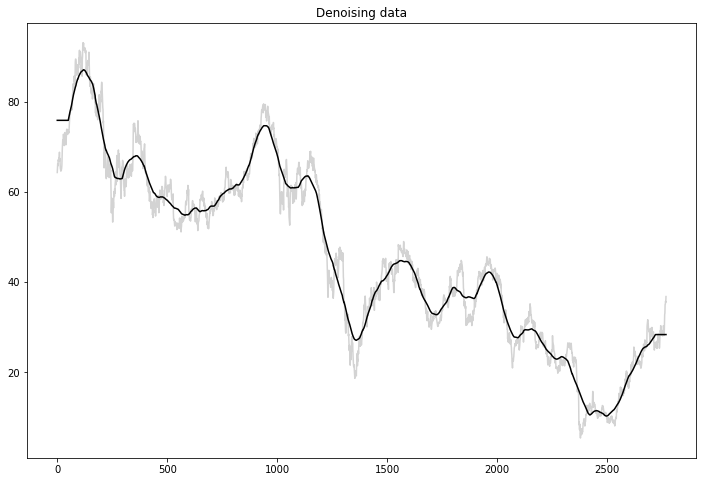

In [ ]:
dfs = pd.read_csv("DVN.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.15, 100, 2300)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.15, .1, .05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values) 
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "DVN", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.15
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.6715 - accuracy: 0.6130 - val_loss: 0.6294 - val_accuracy: 0.6878
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6660 - accuracy: 0.6189 - val_loss: 0.6437 - val_accuracy: 0.6878
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5311 - accuracy: 0.7485 - val_loss: 0.6436 - val_accuracy: 0.6898
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4003 - accuracy: 0.8207 - val_loss: 0.5683 - val_accuracy: 0.6653
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3705 - accuracy: 0.8337 - val_loss: 0.7807 - val_accuracy: 0.6939
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6683 - accuracy: 0.6172 - val_loss: 0.6364 - val_accuracy: 0.6878
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [ ]:
Result_cross.to_csv('DVN_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0          LSTM 0.15  DVN  0.511450  0.693878  0.471831  0.437908
1           GRU 0.15  DVN  0.553571  0.712245  0.467925  0.405229
2       XGBoost 0.15  DVN  0.496774  0.685714  0.500000  0.503268
3        Logreg 0.15  DVN  0.566038  0.716327  0.463320  0.392157
4           SVM 0.15  DVN  0.493333  0.683673  0.488449  0.483660
5     LSTM beta 0.15  DVN  0.441860  0.704595  0.457831  0.475000
6      GRU beta 0.15  DVN  0.405405  0.676149  0.447761  0.500000
7  XGBoost beta 0.15  DVN  0.431034  0.684902  0.510204  0.625000
8   logreg beta 0.15  DVN  0.438462  0.702407  0.456000  0.475000
9      svm beta 0.15  DVN  0.410596  0.678337  0.457565  0.516667
0           LSTM 0.1  DVN  0.493776  0.681633  0.604061  0.777778
1            GRU 0.1  DVN  0.490323  0.681633  0.493506  0.496732
2        XGBoost 0.1  DVN  0.503268  0.689796  0.503268  0.503268
3         Logreg 0.1  DVN  0.558559  0.714286  0.469697  0.405229
4            SVM 0.1  DVN  0.496732  0.685714  0.496732  0.496732
5      LSTM beta 0.1  DVN  0.390411  0.667396  0.428571  0.475000
6       GRU beta 0.1  DVN  0.438462  0.702407  0.456000  0.475000
7   XGBoost beta 0.1  DVN  0.431034  0.684902  0.510204  0.625000
8    logreg beta 0.1  DVN  0.438462  0.702407  0.456000  0.475000
9       svm beta 0.1  DVN  0.410596  0.678337  0.457565  0.516667
0          LSTM 0.05  DVN  0.704819  0.865306  0.780000  0.873134
1           GRU 0.05  DVN  0.782609  0.885714  0.794118  0.805970
2       XGBoost 0.05  DVN  0.740964  0.889796  0.820000  0.917910
3        Logreg 0.05  DVN  0.751724  0.875510  0.781362  0.813433
4           SVM 0.05  DVN  0.737500  0.881633  0.802721  0.880597
5     LSTM beta 0.05  DVN  0.724138  0.849015  0.752688  0.783582
6      GRU beta 0.05  DVN  0.730263  0.859956  0.776224  0.828358
7  XGBoost beta 0.05  DVN  0.702381  0.855580  0.781457  0.880597
8   logreg beta 0.05  DVN  0.768707  0.879650  0.804270  0.843284
9      svm beta 0.05  DVN  0.754717  0.884026  0.819113  0.895522

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
 
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "DVN", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.15
start lstm training...

Epoch 1/5
106/106 [==============================] - 4s 19ms/step - loss: 0.6679 - accuracy: 0.6136 - val_loss: 0.6348 - val_accuracy: 0.6878
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6590 - accuracy: 0.6189 - val_loss: 0.5904 - val_accuracy: 0.6878
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5634 - accuracy: 0.7059 - val_loss: 0.6361 - val_accuracy: 0.6878
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4851 - accuracy: 0.7686 - val_loss: 0.7454 - val_accuracy: 0.6898
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3586 - accuracy: 0.8450 - val_loss: 0.5929 - val_accuracy: 0.6898
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6638 - accuracy: 0.6142 - val_loss: 0.5958 - val_accuracy: 0.6878
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [ ]:
Result_purging.to_csv('DVN_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0          LSTM 0.15  DVN  0.503546  0.689796  0.482993  0.464052
1           GRU 0.15  DVN  0.493333  0.683673  0.488449  0.483660
2       XGBoost 0.15  DVN  0.496774  0.685714  0.500000  0.503268
3        Logreg 0.15  DVN  0.566038  0.716327  0.463320  0.392157
4           SVM 0.15  DVN  0.493333  0.683673  0.488449  0.483660
5     LSTM beta 0.15  DVN  0.421687  0.680525  0.489510  0.583333
6      GRU beta 0.15  DVN  0.404110  0.676149  0.443609  0.491667
7  XGBoost beta 0.15  DVN  0.431034  0.684902  0.510204  0.625000
8   logreg beta 0.15  DVN  0.438462  0.702407  0.456000  0.475000
9      svm beta 0.15  DVN  0.410596  0.678337  0.457565  0.516667
0           LSTM 0.1  DVN  0.493056  0.683673  0.478114  0.464052
1            GRU 0.1  DVN  0.503448  0.689796  0.489933  0.477124
2        XGBoost 0.1  DVN  0.503268  0.689796  0.503268  0.503268
3         Logreg 0.1  DVN  0.558559  0.714286  0.469697  0.405229
4            SVM 0.1  DVN  0.496732  0.685714  0.496732  0.496732
5      LSTM beta 0.1  DVN  0.414815  0.687090  0.439216  0.466667
6       GRU beta 0.1  DVN  0.475000  0.724289  0.475000  0.475000
7   XGBoost beta 0.1  DVN  0.431034  0.684902  0.510204  0.625000
8    logreg beta 0.1  DVN  0.438462  0.702407  0.456000  0.475000
9       svm beta 0.1  DVN  0.410596  0.678337  0.457565  0.516667
0          LSTM 0.05  DVN  0.723684  0.865306  0.769231  0.820896
1           GRU 0.05  DVN  0.769784  0.879592  0.783883  0.798507
2       XGBoost 0.05  DVN  0.740964  0.889796  0.820000  0.917910
3        Logreg 0.05  DVN  0.751724  0.875510  0.781362  0.813433
4           SVM 0.05  DVN  0.737500  0.881633  0.802721  0.880597
5     LSTM beta 0.05  DVN  0.818966  0.868709  0.760000  0.708955
6      GRU beta 0.05  DVN  0.708075  0.853392  0.772881  0.850746
7  XGBoost beta 0.05  DVN  0.702381  0.855580  0.781457  0.880597
8   logreg beta 0.05  DVN  0.768707  0.879650  0.804270  0.843284
9      svm beta 0.05  DVN  0.754717  0.884026  0.819113  0.895522

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('DVN_logreg_beta_p.csv')

## RMD

<TICKER> <PER>    <DATE>  <TIME>  ...   <HIGH>   <LOW>     <CLOSE>   <VOL>
0     US1.RMD     D  20101004       0  ...   32.870   32.28   32.468818  416669
1     US1.RMD     D  20101005       0  ...   33.205   32.65   32.468818  653616
2     US1.RMD     D  20101006       0  ...   33.460   33.16   32.468818  589273
3     US1.RMD     D  20101007       0  ...   33.330   32.59   32.468818  328524
4     US1.RMD     D  20101008       0  ...   33.030   32.43   32.468818  689901
...       ...   ...       ...     ...  ...      ...     ...         ...     ...
2764  US1.RMD     D  20210927       0  ...  277.170  268.44  279.909800    7537
2765  US1.RMD     D  20210928       0  ...  266.290  262.26  279.909800   15954
2766  US1.RMD     D  20210929       0  ...  266.600  263.85  279.909800   15648
2767  US1.RMD     D  20210930       0  ...  269.040  263.96  279.909800    7497
2768  US1.RMD     D  20211001       0  ...  263.250  258.43  279.909800   12671

[2769 rows x 9 columns]

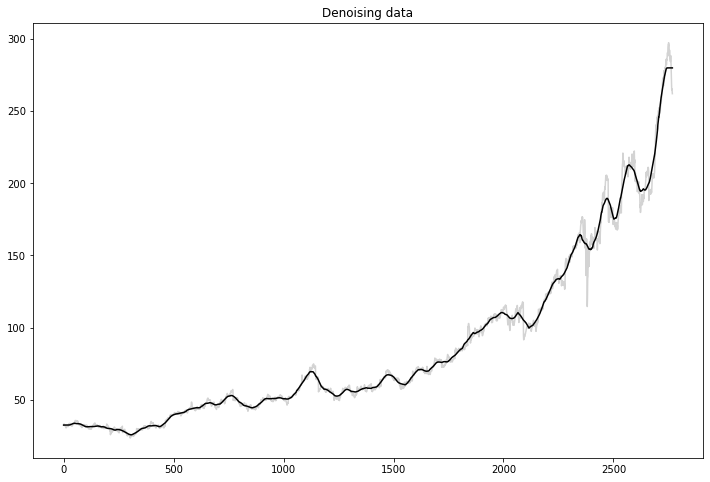

In [ ]:
dfs = pd.read_csv("RMD.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>', 50)
dfs

In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "RMD", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 8s 14ms/step - loss: 0.6128 - accuracy: 0.7077 - val_loss: 0.5634 - val_accuracy: 0.7510
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6087 - accuracy: 0.7107 - val_loss: 0.5701 - val_accuracy: 0.7510
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6048 - accuracy: 0.7107 - val_loss: 0.5566 - val_accuracy: 0.7510
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5093 - accuracy: 0.7527 - val_loss: 0.3529 - val_accuracy: 0.8673
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.4168 - accuracy: 0.8207 - val_loss: 0.3320 - val_accuracy: 0.8653
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 12ms/step - loss: 0.6123 - accuracy: 0.7077 - val_loss: 0.5751 - val_accuracy: 0.7510
Epoch 2/5
106/106 [==============================] - 1s 9ms/step -

In [ ]:
Result_cross.to_csv('RMD_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  RMD  0.859524  0.865306  0.916244  0.980978
1           GRU 0.05  RMD  0.855450  0.861224  0.913924  0.980978
2       XGBoost 0.05  RMD  0.878935  0.887755  0.929577  0.986413
3        Logreg 0.05  RMD  0.809313  0.818367  0.891331  0.991848
4           SVM 0.05  RMD  0.852804  0.865306  0.917085  0.991848
5     LSTM beta 0.05  RMD  0.821244  0.809628  0.879334  0.946269
6      GRU beta 0.05  RMD  0.796610  0.803063  0.879679  0.982090
7  XGBoost beta 0.05  RMD  0.809877  0.816193  0.886486  0.979104
8   logreg beta 0.05  RMD  0.807980  0.807440  0.880435  0.967164
9      svm beta 0.05  RMD  0.805419  0.809628  0.882591  0.976119

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  # dfs = dfs.drop(dfs[dfs.true_labels == 0].index)
  # dfs = dfs[::-1].reset_index()
  #historical = Train_data(dfs[col_name], train_start=100, train_end=round(len(dfs.index)*0.8), test_end=len(dfs.index))
  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "RMD", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 15ms/step - loss: 0.5265 - accuracy: 0.7987 - val_loss: 0.5781 - val_accuracy: 0.7510
Epoch 2/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5066 - accuracy: 0.8047 - val_loss: 0.5644 - val_accuracy: 0.7510
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.5007 - accuracy: 0.8047 - val_loss: 0.5628 - val_accuracy: 0.7510
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4998 - accuracy: 0.8047 - val_loss: 0.5739 - val_accuracy: 0.7510
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4975 - accuracy: 0.8047 - val_loss: 0.5655 - val_accuracy: 0.7510
end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.5095 - accuracy: 0.8007 - val_loss: 0.5857 - val_accuracy: 0.7510
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4591

In [ ]:
Result_purging.to_csv('RMD_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  RMD  0.751020  0.751020  0.857809  1.000000
1           GRU 0.05  RMD  0.846868  0.859184  0.913642  0.991848
2       XGBoost 0.05  RMD  0.851163  0.865306  0.917293  0.994565
3        Logreg 0.05  RMD  0.751020  0.751020  0.857809  1.000000
4           SVM 0.05  RMD  0.844907  0.857143  0.912500  0.991848
5     LSTM beta 0.05  RMD  0.746575  0.739606  0.846054  0.976119
6      GRU beta 0.05  RMD  0.775414  0.776805  0.865435  0.979104
7  XGBoost beta 0.05  RMD  0.807882  0.814004  0.885290  0.979104
8   logreg beta 0.05  RMD  0.769412  0.768053  0.860526  0.976119
9      svm beta 0.05  RMD  0.776722  0.776805  0.865079  0.976119

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RMD_logreg_beta_p.csv')

## WU

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>   <LOW>    <CLOSE>    <VOL>
0      US1.WU     D  20101004       0  ...  17.790  17.360  18.879175  4081478
1      US1.WU     D  20101005       0  ...  17.990  17.400  18.879175  5231417
2      US1.WU     D  20101006       0  ...  18.000  17.570  18.879175  3513358
3      US1.WU     D  20101007       0  ...  17.820  17.540  18.879175  3231681
4      US1.WU     D  20101008       0  ...  17.780  17.500  18.879175  2250995
...       ...   ...       ...     ...  ...     ...     ...        ...      ...
2764   US1.WU     D  20210927       0  ...  20.940  20.450  22.843950   157910
2765   US1.WU     D  20210928       0  ...  21.130  20.755  22.843950   160902
2766   US1.WU     D  20210929       0  ...  20.950  20.660  22.843950    65787
2767   US1.WU     D  20210930       0  ...  20.870  20.215  22.843950   155988
2768   US1.WU     D  20211001       0  ...  20.675  20.160  22.843950   111302

[2769 rows x 9 columns]

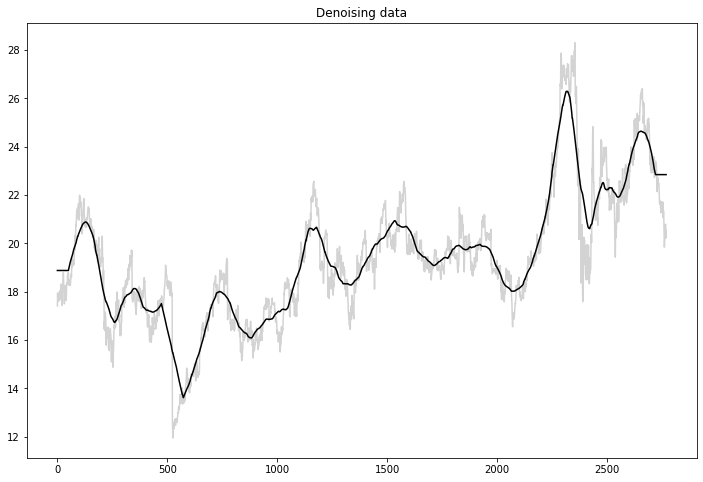

In [ ]:
dfs = pd.read_csv("WU.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [ ]:
col_name = '<CLOSE>'
threshholds = [.1, .05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "WU", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6788 - accuracy: 0.5953 - val_loss: 0.6952 - val_accuracy: 0.5245
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6768 - accuracy: 0.5994 - val_loss: 0.6976 - val_accuracy: 0.5245
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6757 - accuracy: 0.5994 - val_loss: 0.6980 - val_accuracy: 0.5245
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6729 - accuracy: 0.5994 - val_loss: 0.6523 - val_accuracy: 0.6490
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6222 - accuracy: 0.6609 - val_loss: 0.4903 - val_accuracy: 0.8224
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 12ms/step - loss: 0.6759 - accuracy: 0.5775 - val_loss: 0.7144 - val_accuracy: 0.5245
Epoch 2/5
106/106 [==============================] - 1s 9ms/step - 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6912 - accuracy: 0.5278 - val_loss: 0.6924 - val_accuracy: 0.5245
Epoch 2/5
106/106 [==============================] - 1s 9ms/step - loss: 0.6144 - accuracy: 0.6260 - val_loss: 0.4489 - val_accuracy: 0.7612
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3280 - accuracy: 0.8734 - val_loss: 0.3164 - val_accuracy: 0.8265
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3135 - accuracy: 0.8675 - val_loss: 0.2735 - val_accuracy: 0.8551
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3050 - accuracy: 0.8775 - val_loss: 0.2427 - val_accuracy: 0.8939
end training. 

start xgboost training...

[0]	validation_0-auc:0.938069
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.93928
[2]	validation_0-auc:0.941843
[3]	validation_0-auc:0.943404
[4]	validation_0-auc:0.944

In [ ]:
Result_cross.to_csv('WU_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0           LSTM 0.1   WU  0.753472  0.822449  0.833013  0.931330
1            GRU 0.1   WU  0.792727  0.853061  0.858268  0.935622
2        XGBoost 0.1   WU  0.880184  0.861224  0.848889  0.819742
3         Logreg 0.1   WU  1.000000  0.873469  0.846535  0.733906
4            SVM 0.1   WU  0.853755  0.889796  0.888889  0.927039
5      LSTM beta 0.1   WU  1.000000  0.908096  0.900943  0.819742
6       GRU beta 0.1   WU  1.000000  0.916849  0.911215  0.836910
7   XGBoost beta 0.1   WU  0.828194  0.816193  0.817391  0.806867
8    logreg beta 0.1   WU  1.000000  0.886214  0.874396  0.776824
9       svm beta 0.1   WU  1.000000  0.921225  0.916279  0.845494
0          LSTM 0.05   WU  0.000000  0.524490  0.000000  0.000000
1           GRU 0.05   WU  0.933014  0.893878  0.882353  0.836910
2       XGBoost 0.05   WU  0.845494  0.853061  0.845494  0.845494
3        Logreg 0.05   WU  0.941748  0.895918  0.883827  0.832618
4           SVM 0.05   WU  0.798535  0.857143  0.861660  0.935622
5     LSTM beta 0.05   WU  1.000000  0.892779  0.882494  0.789700
6      GRU beta 0.05   WU  0.868085  0.868709  0.871795  0.875536
7  XGBoost beta 0.05   WU  0.827273  0.805252  0.803532  0.781116
8   logreg beta 0.05   WU  1.000000  0.923414  0.918794  0.849785
9      svm beta 0.05   WU  0.980198  0.914661  0.910345  0.849785

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_logreg_beta.csv')

###Purging

In [ ]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=300, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "WU", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.1
start lstm training...

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 0.6920 - accuracy: 0.5450 - val_loss: 0.6935 - val_accuracy: 0.5245
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6886 - accuracy: 0.5564 - val_loss: 0.6918 - val_accuracy: 0.5245
Epoch 3/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6881 - accuracy: 0.5564 - val_loss: 0.6932 - val_accuracy: 0.5245
Epoch 4/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6871 - accuracy: 0.5584 - val_loss: 0.6911 - val_accuracy: 0.5245
Epoch 5/5
94/94 [==============================] - 1s 11ms/step - loss: 0.6876 - accuracy: 0.5570 - val_loss: 0.6898 - val_accuracy: 0.5245


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



end training. 

start gru training...

Epoch 1/5
94/94 [==============================] - 3s 13ms/step - loss: 0.6907 - accuracy: 0.5537 - val_loss: 0.6877 - val_accuracy: 0.5245
Epoch 2/5
94/94 [==============================] - 1s 10ms/step - loss: 0.6787 - accuracy: 0.5644 - val_loss: 0.6458 - val_accuracy: 0.8918
Epoch 3/5
94/94 [==============================] - 1s 10ms/step - loss: 0.4674 - accuracy: 0.7906 - val_loss: 0.2620 - val_accuracy: 0.8878
Epoch 4/5
94/94 [==============================] - 1s 10ms/step - loss: 0.3603 - accuracy: 0.8329 - val_loss: 0.2496 - val_accuracy: 0.9082
Epoch 5/5
94/94 [==============================] - 1s 10ms/step - loss: 0.3513 - accuracy: 0.8383 - val_loss: 0.2325 - val_accuracy: 0.8939
end training. 

start xgboost training...

[0]	validation_0-auc:0.940691
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.94682
[2]	validation_0-auc:0.94641
[3]	validation_0-auc:0.946277
[4]	validation_0-auc:0.9456
[5]	vali

In [ ]:
Result_purging.to_csv('WU_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0           LSTM 0.1   WU  0.000000  0.524490  0.000000  0.000000
1            GRU 0.1   WU  0.933014  0.893878  0.882353  0.836910
2        XGBoost 0.1   WU  0.906542  0.879592  0.868009  0.832618
3         Logreg 0.1   WU  1.000000  0.891837  0.871671  0.772532
4            SVM 0.1   WU  0.847059  0.885714  0.885246  0.927039
5      LSTM beta 0.1   WU  1.000000  0.890591  0.879808  0.785408
6       GRU beta 0.1   WU  0.796154  0.827133  0.839757  0.888412
7   XGBoost beta 0.1   WU  0.932642  0.855580  0.845070  0.772532
8    logreg beta 0.1   WU  1.000000  0.914661  0.908665  0.832618
9       svm beta 0.1   WU  0.994949  0.919037  0.914153  0.845494
0          LSTM 0.05   WU  0.901288  0.906122  0.901288  0.901288
1           GRU 0.05   WU  0.857143  0.891837  0.890722  0.927039
2       XGBoost 0.05   WU  0.809917  0.830612  0.825263  0.841202
3        Logreg 0.05   WU  0.937500  0.895918  0.884354  0.836910
4           SVM 0.05   WU  0.784946  0.848980  0.855469  0.939914
5     LSTM beta 0.05   WU  1.000000  0.899344  0.890476  0.802575
6      GRU beta 0.05   WU  0.791667  0.827133  0.841046  0.896996
7  XGBoost beta 0.05   WU  0.962963  0.873085  0.862559  0.781116
8   logreg beta 0.05   WU  1.000000  0.916849  0.911215  0.836910
9      svm beta 0.05   WU  0.980100  0.912473  0.907834  0.845494

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WU_logreg_beta_p.csv')

## AMT

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>    <LOW>     <CLOSE>    <VOL>
0     US1.AMT     D  20101004       0  ...   51.84   50.855   51.263667  2776426
1     US1.AMT     D  20101005       0  ...   52.34   51.390   51.263667  2281804
2     US1.AMT     D  20101006       0  ...   52.05   50.310   51.263667  3568106
3     US1.AMT     D  20101007       0  ...   51.63   50.310   51.263667  3668859
4     US1.AMT     D  20101008       0  ...   50.56   50.130   51.263667  2086997
...       ...   ...       ...     ...  ...     ...      ...         ...      ...
2762  US1.AMT     D  20210927       0  ...  280.71  273.670  288.823000    59047
2763  US1.AMT     D  20210928       0  ...  271.81  266.860  288.823000    76212
2764  US1.AMT     D  20210929       0  ...  271.24  268.440  288.823000    43260
2765  US1.AMT     D  20210930       0  ...  272.14  265.300  288.823000    50333
2766  US1.AMT     D  20211001       0  ...  268.98  265.440  288.823000    33744

[2767 rows x 9 columns]

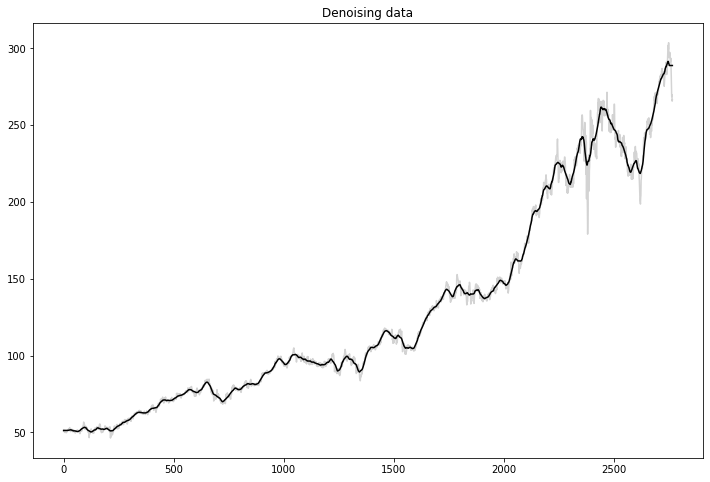

In [58]:
dfs = pd.read_csv("AMT.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>', k=30)
dfs

In [59]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [60]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
 
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "AMT", step_sizes=4, th= th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.5902 - accuracy: 0.7373 - val_loss: 0.6280 - val_accuracy: 0.6816
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5832 - accuracy: 0.7391 - val_loss: 0.6272 - val_accuracy: 0.6816
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5823 - accuracy: 0.7391 - val_loss: 0.6300 - val_accuracy: 0.6816
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5754 - accuracy: 0.7391 - val_loss: 0.6260 - val_accuracy: 0.6816
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5823 - accuracy: 0.7314 - val_loss: 0.6259 - val_accuracy: 0.6816
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 12ms/step - loss: 0.5850 - accuracy: 0.7396 - val_loss: 0.6329 - val_accuracy: 0.6816
Epoch 2/5
106/106 [==============================] - 1s 9ms/step -

In [61]:
Result_cross.to_csv('AMT_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  AMT  0.681633  0.681633  0.810680  1.000000
1           GRU 0.05  AMT  0.804749  0.789796  0.855540  0.913174
2       XGBoost 0.05  AMT  0.805263  0.791837  0.857143  0.916168
3        Logreg 0.05  AMT  0.681633  0.681633  0.810680  1.000000
4           SVM 0.05  AMT  0.806789  0.797959  0.861925  0.925150
5     LSTM beta 0.05  AMT  0.809140  0.772429  0.852691  0.901198
6      GRU beta 0.05  AMT  0.812339  0.800875  0.874136  0.946108
7  XGBoost beta 0.05  AMT  0.822404  0.785558  0.860000  0.901198
8   logreg beta 0.05  AMT  0.784173  0.787746  0.870839  0.979042
9      svm beta 0.05  AMT  0.832891  0.818381  0.883263  0.940120

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_logreg_beta.csv')

###Purging

In [62]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "AMT", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.5929 - accuracy: 0.7361 - val_loss: 0.6359 - val_accuracy: 0.6816
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5842 - accuracy: 0.7391 - val_loss: 0.6308 - val_accuracy: 0.6816
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5787 - accuracy: 0.7391 - val_loss: 0.6263 - val_accuracy: 0.6816
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5752 - accuracy: 0.7391 - val_loss: 0.6309 - val_accuracy: 0.6816
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5775 - accuracy: 0.7391 - val_loss: 0.6371 - val_accuracy: 0.6816
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.5846 - accuracy: 0.7367 - val_loss: 0.6216 - val_accuracy: 0.6816
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [63]:
Result_purging.to_csv('AMT_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  AMT  0.681633  0.681633  0.810680  1.000000
1           GRU 0.05  AMT  0.767816  0.793878  0.868661  1.000000
2       XGBoost 0.05  AMT  0.805263  0.791837  0.857143  0.916168
3        Logreg 0.05  AMT  0.681633  0.681633  0.810680  1.000000
4           SVM 0.05  AMT  0.806789  0.797959  0.861925  0.925150
5     LSTM beta 0.05  AMT  0.806452  0.768053  0.849858  0.898204
6      GRU beta 0.05  AMT  0.821053  0.803063  0.873950  0.934132
7  XGBoost beta 0.05  AMT  0.822404  0.785558  0.860000  0.901198
8   logreg beta 0.05  AMT  0.784173  0.787746  0.870839  0.979042
9      svm beta 0.05  AMT  0.832891  0.818381  0.883263  0.940120

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('AMT_logreg_beta_p.csv')

## CL

<TICKER> <PER>    <DATE>  <TIME>  <OPEN>  <HIGH>  <LOW>   <CLOSE>    <VOL>
0      US1.CL     D  20101004       0   76.46   77.24  76.25  74.74750  2872127
1      US1.CL     D  20101005       0   75.90   76.10  74.40  74.74750  7170535
2      US1.CL     D  20101006       0   74.73   75.04  73.75  74.74750  4674296
3      US1.CL     D  20101007       0   74.63   74.63  73.67  74.37000  3563991
4      US1.CL     D  20101008       0   73.77   75.04  73.62  74.36750  3042250
...       ...   ...       ...     ...     ...     ...    ...       ...      ...
2764   US1.CL     D  20210927       0   76.58   76.65  75.92  76.29375   144858
2765   US1.CL     D  20210928       0   75.79   76.15  75.41  76.39000   227270
2766   US1.CL     D  20210929       0   75.89   77.35  75.72  76.12625   244930
2767   US1.CL     D  20210930       0   77.24   77.24  75.59  76.00875   208601
2768   US1.CL     D  20211001       0   75.76   75.98  75.07  76.00875   154087

[2769 rows x 9 columns]

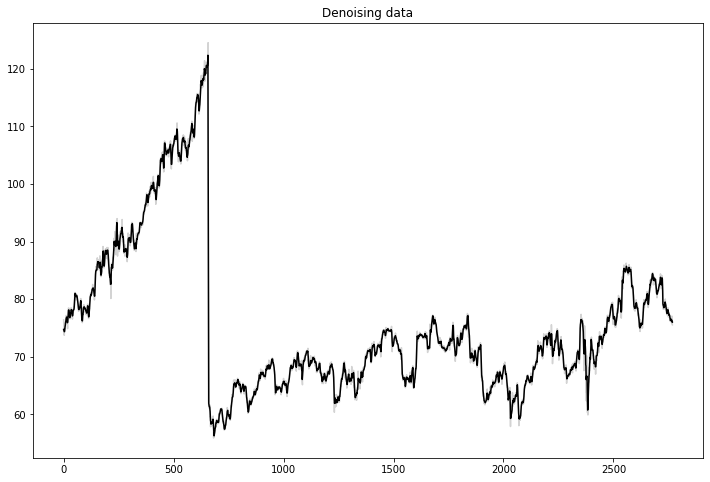

In [109]:
dfs = pd.read_csv("CL.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>', k=4)
dfs

In [110]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [111]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "CL", step_sizes=4, th= th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6553 - accuracy: 0.6485 - val_loss: 0.6353 - val_accuracy: 0.6776
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6507 - accuracy: 0.6515 - val_loss: 0.6316 - val_accuracy: 0.6776
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6409 - accuracy: 0.6562 - val_loss: 0.6120 - val_accuracy: 0.6776
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6238 - accuracy: 0.6710 - val_loss: 0.5792 - val_accuracy: 0.7245
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5959 - accuracy: 0.6923 - val_loss: 0.5255 - val_accuracy: 0.7857
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6513 - accuracy: 0.6444 - val_loss: 0.6205 - val_accuracy: 0.6776
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [112]:
Result_cross.to_csv('CL_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0          LSTM 0.05   CL  0.801061  0.785714  0.851904  0.909639
1           GRU 0.05   CL  0.821809  0.816327  0.872881  0.930723
2       XGBoost 0.05   CL  0.847059  0.804082  0.857143  0.867470
3        Logreg 0.05   CL  0.799479  0.791837  0.857542  0.924699
4           SVM 0.05   CL  0.831099  0.826531  0.879433  0.933735
5     LSTM beta 0.05   CL  0.781421  0.787746  0.855007  0.943894
6      GRU beta 0.05   CL  0.808989  0.818381  0.874052  0.950495
7  XGBoost beta 0.05   CL  0.851485  0.803063  0.851485  0.851485
8   logreg beta 0.05   CL  0.816514  0.789934  0.847619  0.881188
9      svm beta 0.05   CL  0.846154  0.809628  0.858537  0.871287

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_logreg_beta.csv')

###Purging

In [113]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "CL", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6550 - accuracy: 0.6485 - val_loss: 0.6321 - val_accuracy: 0.6776
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6508 - accuracy: 0.6515 - val_loss: 0.6331 - val_accuracy: 0.6776
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6419 - accuracy: 0.6491 - val_loss: 0.6253 - val_accuracy: 0.6449
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6214 - accuracy: 0.6485 - val_loss: 0.5592 - val_accuracy: 0.7041
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5973 - accuracy: 0.6846 - val_loss: 0.5344 - val_accuracy: 0.7694
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 12ms/step - loss: 0.6489 - accuracy: 0.6556 - val_loss: 0.6058 - val_accuracy: 0.6776
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [114]:
Result_purging.to_csv('CL_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0          LSTM 0.05   CL  0.817391  0.769388  0.833087  0.849398
1           GRU 0.05   CL  0.825737  0.818367  0.873759  0.927711
2       XGBoost 0.05   CL  0.847059  0.804082  0.857143  0.867470
3        Logreg 0.05   CL  0.799479  0.791837  0.857542  0.924699
4           SVM 0.05   CL  0.831099  0.826531  0.879433  0.933735
5     LSTM beta 0.05   CL  0.788301  0.789934  0.854985  0.933993
6      GRU beta 0.05   CL  0.863333  0.814004  0.859038  0.854785
7  XGBoost beta 0.05   CL  0.851485  0.803063  0.851485  0.851485
8   logreg beta 0.05   CL  0.816514  0.789934  0.847619  0.881188
9      svm beta 0.05   CL  0.846154  0.809628  0.858537  0.871287

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CL_logreg_beta_p.csv')

## CPRI

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>  <LOW>  <CLOSE>     <VOL>
0     US1.CPRI     D  20111215       0  ...   25.19  23.51  26.8072  31936188
1     US1.CPRI     D  20111216       0  ...   24.80  23.51  26.8072   3921157
2     US1.CPRI     D  20111219       0  ...   25.09  24.31  26.8072   3133441
3     US1.CPRI     D  20111220       0  ...   25.76  25.02  26.8072   1697064
4     US1.CPRI     D  20111221       0  ...   26.78  25.46  26.8072   2485638
...        ...   ...       ...     ...  ...     ...    ...      ...       ...
2460  US1.CPRI     D  20210927       0  ...   53.40  52.69  53.7850     43844
2461  US1.CPRI     D  20210928       0  ...   53.13  52.07  53.7850     15965
2462  US1.CPRI     D  20210929       0  ...   52.96  51.17  53.7850     16510
2463  US1.CPRI     D  20210930       0  ...   50.73  48.33  53.7850     51156
2464  US1.CPRI     D  20211001       0  ...   50.18  47.93  53.7850     37955

[2465 rows x 9 columns]

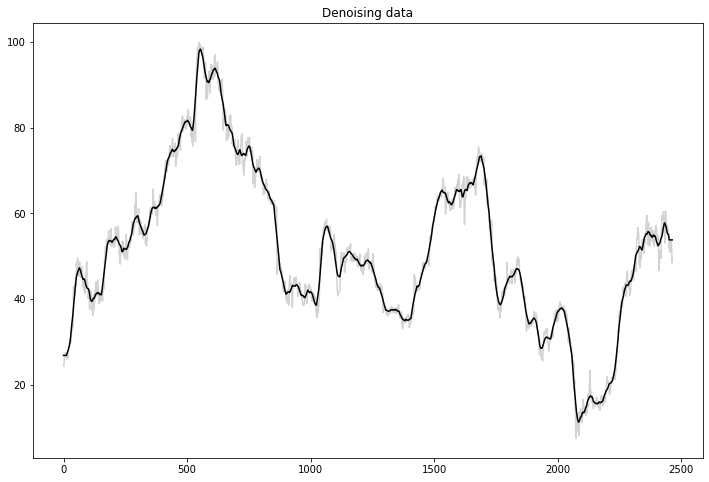

In [83]:
dfs = pd.read_csv("CPRI.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>', k=25)
dfs

In [84]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [85]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)
  
  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "CPRI", step_sizes=4, th= th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 4s 14ms/step - loss: 0.6966 - accuracy: 0.5041 - val_loss: 0.6942 - val_accuracy: 0.4020
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6124 - accuracy: 0.6391 - val_loss: 0.4079 - val_accuracy: 0.8571
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.4646 - accuracy: 0.7905 - val_loss: 0.3095 - val_accuracy: 0.8714
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.4159 - accuracy: 0.8107 - val_loss: 0.3228 - val_accuracy: 0.8531
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4009 - accuracy: 0.8065 - val_loss: 0.2966 - val_accuracy: 0.8714
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6322 - accuracy: 0.6497 - val_loss: 0.2909 - val_accuracy: 0.8592
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [86]:
Result_cross.to_csv('CPRI_Result_cross.csv')
Result_cross

Model  Name      Perc       acc        f1     recal
0          LSTM 0.05  CPRI  0.880795  0.871429  0.894118  0.907850
1           GRU 0.05  CPRI  0.907473  0.869388  0.888502  0.870307
2       XGBoost 0.05  CPRI  0.903654  0.897959  0.915825  0.928328
3        Logreg 0.05  CPRI  0.899306  0.871429  0.891566  0.883959
4           SVM 0.05  CPRI  0.837423  0.851020  0.882068  0.931741
5     LSTM beta 0.05  CPRI  0.877778  0.859956  0.881041  0.884328
6      GRU beta 0.05  CPRI  0.867925  0.840263  0.863039  0.858209
7  XGBoost beta 0.05  CPRI  0.867925  0.840263  0.863039  0.858209
8   logreg beta 0.05  CPRI  0.889313  0.859956  0.879245  0.869403
9      svm beta 0.05  CPRI  0.818182  0.811816  0.844765  0.873134

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_logreg_beta.csv')

###Purging

In [87]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "CPRI", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6936 - accuracy: 0.5249 - val_loss: 0.6779 - val_accuracy: 0.8980
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5479 - accuracy: 0.7018 - val_loss: 0.3153 - val_accuracy: 0.8714
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4243 - accuracy: 0.8101 - val_loss: 0.3217 - val_accuracy: 0.8449
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.4098 - accuracy: 0.8136 - val_loss: 0.2965 - val_accuracy: 0.8694
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3949 - accuracy: 0.8195 - val_loss: 0.3046 - val_accuracy: 0.8592
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6406 - accuracy: 0.6053 - val_loss: 0.2734 - val_accuracy: 0.8735
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [88]:
Result_purging.to_csv('CPRI_Result_purging.csv')
Result_purging

Model  Name      Perc       acc        f1     recal
0          LSTM 0.05  CPRI  0.921053  0.859184  0.876565  0.836177
1           GRU 0.05  CPRI  0.904594  0.869388  0.888889  0.873720
2       XGBoost 0.05  CPRI  0.903654  0.897959  0.915825  0.928328
3        Logreg 0.05  CPRI  0.899306  0.871429  0.891566  0.883959
4           SVM 0.05  CPRI  0.837423  0.851020  0.882068  0.931741
5     LSTM beta 0.05  CPRI  0.894531  0.855580  0.874046  0.854478
6      GRU beta 0.05  CPRI  0.880597  0.859956  0.880597  0.880597
7  XGBoost beta 0.05  CPRI  0.867925  0.840263  0.863039  0.858209
8   logreg beta 0.05  CPRI  0.889313  0.859956  0.879245  0.869403
9      svm beta 0.05  CPRI  0.818182  0.811816  0.844765  0.873134

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('CPRI_logreg_beta_p.csv')

## FCX

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>    <LOW>   <CLOSE>     <VOL>
0     US1.FCX     D  20101004       0  ...  88.590  86.6700  98.00829  11292152
1     US1.FCX     D  20101005       0  ...  91.800  88.6100  98.00829  12610936
2     US1.FCX     D  20101006       0  ...  94.360  91.4500  98.00829  13105657
3     US1.FCX     D  20101007       0  ...  93.870  89.8500  98.00829  13153770
4     US1.FCX     D  20101008       0  ...  95.910  92.0002  98.00829  12656521
...       ...   ...       ...     ...  ...     ...      ...       ...       ...
2764  US1.FCX     D  20210927       0  ...  33.950  32.2900  36.87365   1099291
2765  US1.FCX     D  20210928       0  ...  34.015  32.8200  36.87365    910310
2766  US1.FCX     D  20210929       0  ...  34.010  32.9200  36.87365    589350
2767  US1.FCX     D  20210930       0  ...  33.750  32.5300  36.87365   1359849
2768  US1.FCX     D  20211001       0  ...  33.100  31.8700  36.87365    805504

[2769 rows x 9 columns]

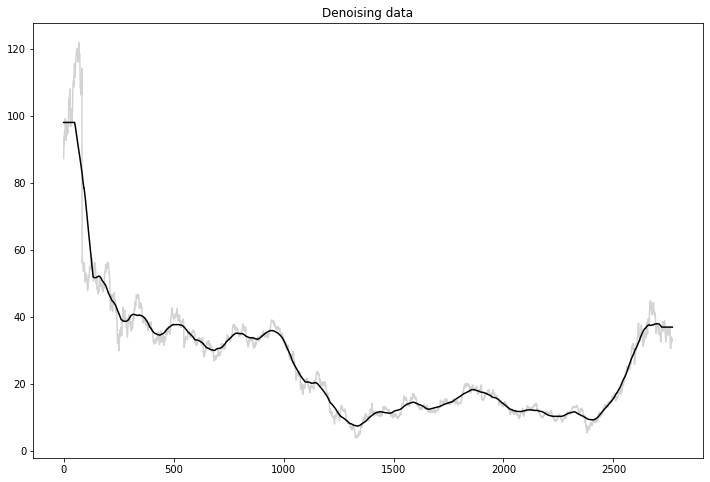

In [115]:
dfs = pd.read_csv("FCX.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [ ]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [116]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "FCX", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6788 - accuracy: 0.5988 - val_loss: 0.5640 - val_accuracy: 0.7939
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6704 - accuracy: 0.6118 - val_loss: 0.5725 - val_accuracy: 0.7939
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5234 - accuracy: 0.7207 - val_loss: 0.2778 - val_accuracy: 0.9000
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2695 - accuracy: 0.9041 - val_loss: 0.3264 - val_accuracy: 0.8816
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2347 - accuracy: 0.9225 - val_loss: 0.2383 - val_accuracy: 0.9041
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6462 - accuracy: 0.6148 - val_loss: 0.5373 - val_accuracy: 0.9265
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [117]:
Result_cross.to_csv('FCX_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  FCX  0.745455  0.904082  0.777251  0.811881
1           GRU 0.05  FCX  0.713115  0.900000  0.780269  0.861386
2       XGBoost 0.05  FCX  0.681818  0.891837  0.772532  0.891089
3        Logreg 0.05  FCX  0.713115  0.900000  0.780269  0.861386
4           SVM 0.05  FCX  0.719008  0.902041  0.783784  0.861386
5     LSTM beta 0.05  FCX  0.472222  0.838074  0.579545  0.750000
6      GRU beta 0.05  FCX  0.542553  0.868709  0.629630  0.750000
7  XGBoost beta 0.05  FCX  0.477876  0.840263  0.596685  0.794118
8   logreg beta 0.05  FCX  0.485981  0.844639  0.594286  0.764706
9      svm beta 0.05  FCX  0.540816  0.868709  0.638554  0.779412

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_logreg_beta.csv')

###Purging

In [118]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "FCX", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6754 - accuracy: 0.6154 - val_loss: 0.5678 - val_accuracy: 0.7939
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5276 - accuracy: 0.7367 - val_loss: 0.2669 - val_accuracy: 0.9061
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3285 - accuracy: 0.8751 - val_loss: 0.4445 - val_accuracy: 0.8327
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2774 - accuracy: 0.8893 - val_loss: 0.8236 - val_accuracy: 0.7510
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2946 - accuracy: 0.8858 - val_loss: 0.2278 - val_accuracy: 0.9245
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 18ms/step - loss: 0.6664 - accuracy: 0.6148 - val_loss: 0.5729 - val_accuracy: 0.7939
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [119]:
Result_purging.to_csv('FCX_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  FCX  0.833333  0.924490  0.812183  0.792079
1           GRU 0.05  FCX  0.671642  0.887755  0.765957  0.891089
2       XGBoost 0.05  FCX  0.681818  0.891837  0.772532  0.891089
3        Logreg 0.05  FCX  0.713115  0.900000  0.780269  0.861386
4           SVM 0.05  FCX  0.719008  0.902041  0.783784  0.861386
5     LSTM beta 0.05  FCX  0.470588  0.838074  0.564706  0.705882
6      GRU beta 0.05  FCX  0.563830  0.877462  0.654321  0.779412
7  XGBoost beta 0.05  FCX  0.477876  0.840263  0.596685  0.794118
8   logreg beta 0.05  FCX  0.485981  0.844639  0.594286  0.764706
9      svm beta 0.05  FCX  0.540816  0.868709  0.638554  0.779412

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FCX_logreg_beta_p.csv')

## FOX

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>  <LOW>    <CLOSE>    <VOL>
0     US1.FOX     D  20101004       0  ...   15.24  14.90  16.463422  1805146
1     US1.FOX     D  20101005       0  ...   15.58  15.24  16.463422  2117362
2     US1.FOX     D  20101006       0  ...   15.67  15.41  16.463422  2451013
3     US1.FOX     D  20101007       0  ...   15.71  15.33  16.463422  2236400
4     US1.FOX     D  20101008       0  ...   15.85  15.54  16.463422  1297198
...       ...   ...       ...     ...  ...     ...    ...        ...      ...
2752  US1.FOX     D  20210927       0  ...   37.19  36.38  34.912400    34743
2753  US1.FOX     D  20210928       0  ...   37.35  36.76  34.912400    31023
2754  US1.FOX     D  20210929       0  ...   37.32  36.66  34.912400    29082
2755  US1.FOX     D  20210930       0  ...   37.99  37.11  34.912400    49472
2756  US1.FOX     D  20211001       0  ...   37.92  37.13  34.912400    25772

[2757 rows x 9 columns]

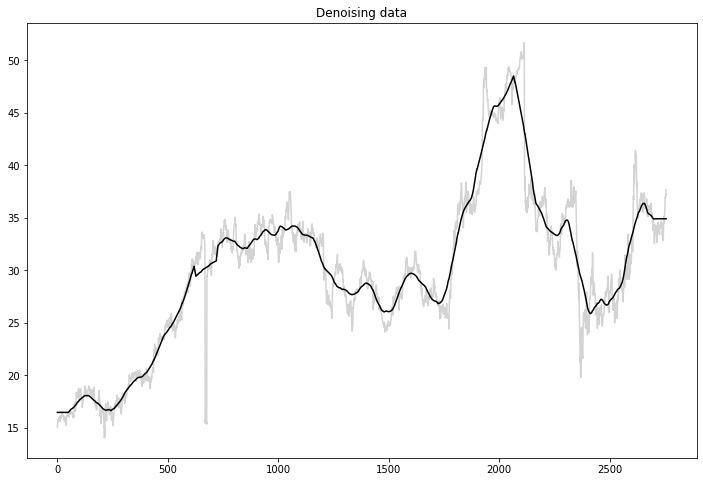

In [121]:
dfs = pd.read_csv("FOX.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [122]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [123]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "FOX", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6709 - accuracy: 0.6148 - val_loss: 0.7124 - val_accuracy: 0.5224
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6701 - accuracy: 0.6148 - val_loss: 0.7094 - val_accuracy: 0.5224
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6316 - accuracy: 0.6462 - val_loss: 0.4894 - val_accuracy: 0.8000
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4788 - accuracy: 0.7722 - val_loss: 0.3774 - val_accuracy: 0.8796
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.4137 - accuracy: 0.8107 - val_loss: 0.3083 - val_accuracy: 0.9204
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6705 - accuracy: 0.6172 - val_loss: 0.6803 - val_accuracy: 0.5224
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [124]:
Result_cross.to_csv('FOX_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  FOX  0.867797  0.920408  0.929220  1.000000
1           GRU 0.05  FOX  0.873239  0.910204  0.918519  0.968750
2       XGBoost 0.05  FOX  0.730769  0.795918  0.831650  0.964844
3        Logreg 0.05  FOX  0.752941  0.828571  0.859060  1.000000
4           SVM 0.05  FOX  0.744186  0.820408  0.853333  1.000000
5     LSTM beta 0.05  FOX  0.838346  0.905908  0.912065  1.000000
6      GRU beta 0.05  FOX  0.838346  0.905908  0.912065  1.000000
7  XGBoost beta 0.05  FOX  0.835206  0.903720  0.910204  1.000000
8   logreg beta 0.05  FOX  0.838346  0.905908  0.912065  1.000000
9      svm beta 0.05  FOX  0.703470  0.794311  0.825926  1.000000

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_logreg_beta.csv')

###Purging

In [125]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "FOX", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6740 - accuracy: 0.6118 - val_loss: 0.6997 - val_accuracy: 0.5224
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6693 - accuracy: 0.6148 - val_loss: 0.7020 - val_accuracy: 0.5224
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6639 - accuracy: 0.6172 - val_loss: 0.6036 - val_accuracy: 0.9184
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5750 - accuracy: 0.6876 - val_loss: 0.6235 - val_accuracy: 0.7041
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5252 - accuracy: 0.7302 - val_loss: 0.4776 - val_accuracy: 0.8327
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 12ms/step - loss: 0.6724 - accuracy: 0.6101 - val_loss: 0.7034 - val_accuracy: 0.5224
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [126]:
Result_purging.to_csv('FOX_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  FOX  0.757396  0.832653  0.861953  1.000000
1           GRU 0.05  FOX  0.868512  0.912245  0.921101  0.980469
2       XGBoost 0.05  FOX  0.730769  0.795918  0.831650  0.964844
3        Logreg 0.05  FOX  0.752941  0.828571  0.859060  1.000000
4           SVM 0.05  FOX  0.744186  0.820408  0.853333  1.000000
5     LSTM beta 0.05  FOX  0.851145  0.914661  0.919588  1.000000
6      GRU beta 0.05  FOX  0.851145  0.914661  0.919588  1.000000
7  XGBoost beta 0.05  FOX  0.835206  0.903720  0.910204  1.000000
8   logreg beta 0.05  FOX  0.838346  0.905908  0.912065  1.000000
9      svm beta 0.05  FOX  0.703470  0.794311  0.825926  1.000000

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOX_logreg_beta_p.csv')

## FOXA

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>    <LOW>    <CLOSE>     <VOL>
0     US1.FOXA     D  20101004       0  ...  13.250  12.8800  14.827651  15096088
1     US1.FOXA     D  20101005       0  ...  13.580  13.1700  14.827651  17732763
2     US1.FOXA     D  20101006       0  ...  13.650  13.3200  14.827651  16218875
3     US1.FOXA     D  20101007       0  ...  13.750  13.3100  14.827651  28318775
4     US1.FOXA     D  20101008       0  ...  13.950  13.5675  14.827651  20812401
...        ...   ...       ...     ...  ...     ...      ...        ...       ...
2764  US1.FOXA     D  20210927       0  ...  40.370  39.1000  37.092250    180216
2765  US1.FOXA     D  20210928       0  ...  40.420  39.7000  37.092250    163999
2766  US1.FOXA     D  20210929       0  ...  40.310  39.6500  37.092250     91517
2767  US1.FOXA     D  20210930       0  ...  41.060  40.1100  37.092250    158785
2768  US1.FOXA     D  20211001       0  ...  41.065  40.1200  37.092250     76891

[2769 rows x 9 columns]

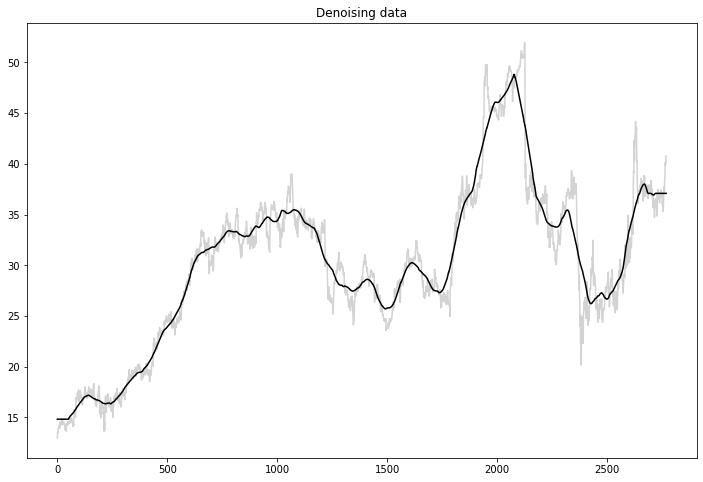

In [127]:
dfs = pd.read_csv("FOXA.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [128]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [129]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "FOXA", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6346 - accuracy: 0.6817 - val_loss: 0.7215 - val_accuracy: 0.5449
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6247 - accuracy: 0.6799 - val_loss: 0.6472 - val_accuracy: 0.5449
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5794 - accuracy: 0.6988 - val_loss: 0.3802 - val_accuracy: 0.8939
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.4400 - accuracy: 0.8012 - val_loss: 0.2957 - val_accuracy: 0.8816
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.4245 - accuracy: 0.8053 - val_loss: 0.4129 - val_accuracy: 0.8449
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6394 - accuracy: 0.6793 - val_loss: 0.7160 - val_accuracy: 0.5449
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [130]:
Result_cross.to_csv('FOXA_Result_cross.csv')
Result_cross

Model  Name      Perc       acc        f1  recal
0          LSTM 0.05  FOXA  0.778426  0.844898  0.875410    1.0
1           GRU 0.05  FOXA  0.811550  0.873469  0.895973    1.0
2       XGBoost 0.05  FOXA  0.839623  0.895918  0.912821    1.0
3        Logreg 0.05  FOXA  0.717742  0.785714  0.835681    1.0
4           SVM 0.05  FOXA  0.799401  0.863265  0.888519    1.0
5     LSTM beta 0.05  FOXA  0.512035  0.512035  0.677279    1.0
6      GRU beta 0.05  FOXA  0.823944  0.890591  0.903475    1.0
7  XGBoost beta 0.05  FOXA  0.818182  0.886214  0.900000    1.0
8   logreg beta 0.05  FOXA  0.806897  0.877462  0.893130    1.0
9      svm beta 0.05  FOXA  0.752412  0.831510  0.858716    1.0

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_logreg_beta.csv')

###Purging

In [131]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "FOXA", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6381 - accuracy: 0.6751 - val_loss: 0.7083 - val_accuracy: 0.5449
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6345 - accuracy: 0.6805 - val_loss: 0.7222 - val_accuracy: 0.5449
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6306 - accuracy: 0.6805 - val_loss: 0.7189 - val_accuracy: 0.5449
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6244 - accuracy: 0.6805 - val_loss: 0.7066 - val_accuracy: 0.5449
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6204 - accuracy: 0.6781 - val_loss: 0.7168 - val_accuracy: 0.5449
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6325 - accuracy: 0.6775 - val_loss: 0.7261 - val_accuracy: 0.5449
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [132]:
Result_purging.to_csv('FOXA_Result_purging.csv')
Result_purging

Model  Name      Perc       acc        f1  recal
0          LSTM 0.05  FOXA  0.544898  0.544898  0.705416    1.0
1           GRU 0.05  FOXA  0.819018  0.879592  0.900506    1.0
2       XGBoost 0.05  FOXA  0.839623  0.895918  0.912821    1.0
3        Logreg 0.05  FOXA  0.717742  0.785714  0.835681    1.0
4           SVM 0.05  FOXA  0.799401  0.863265  0.888519    1.0
5     LSTM beta 0.05  FOXA  0.841727  0.903720  0.914062    1.0
6      GRU beta 0.05  FOXA  0.826855  0.892779  0.905222    1.0
7  XGBoost beta 0.05  FOXA  0.818182  0.886214  0.900000    1.0
8   logreg beta 0.05  FOXA  0.806897  0.877462  0.893130    1.0
9      svm beta 0.05  FOXA  0.752412  0.831510  0.858716    1.0

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('FOXA_logreg_beta_p.csv')

## M

<TICKER> <PER>    <DATE>  <TIME>  ...   <HIGH>  <LOW>    <CLOSE>     <VOL>
0       US1.M     D  20101004       0  ...  22.7700  22.01  24.253651  11287243
1       US1.M     D  20101005       0  ...  23.7000  23.08  24.253651  10283908
2       US1.M     D  20101006       0  ...  23.7300  23.09  24.253651   9486082
3       US1.M     D  20101007       0  ...  23.9800  23.25  24.253651   9219821
4       US1.M     D  20101008       0  ...  24.5025  23.83  24.253651   8712993
...       ...   ...       ...     ...  ...      ...    ...        ...       ...
2764    US1.M     D  20210927       0  ...  25.1500  23.91  19.502250    738222
2765    US1.M     D  20210928       0  ...  25.4500  24.58  19.502250    854636
2766    US1.M     D  20210929       0  ...  25.4600  24.67  19.502250    386601
2767    US1.M     D  20210930       0  ...  23.9000  22.34  19.502250   1239730
2768    US1.M     D  20211001       0  ...  23.1400  22.21  19.502250    703439

[2769 rows x 9 columns]

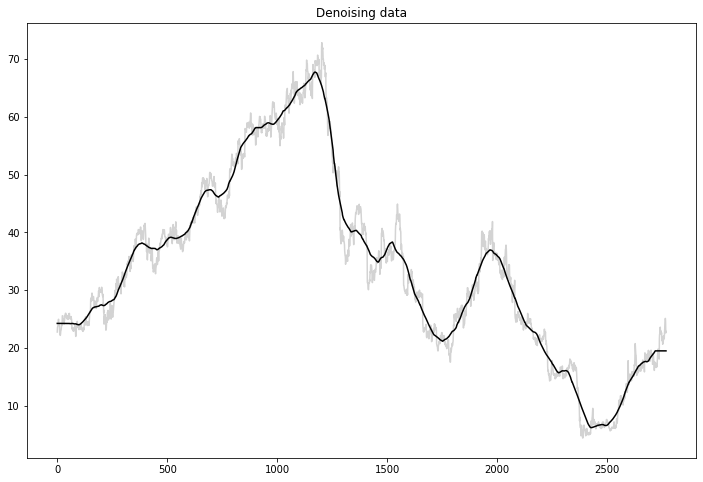

In [133]:
dfs = pd.read_csv("M.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [134]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [135]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "M", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6259 - accuracy: 0.6941 - val_loss: 0.8779 - val_accuracy: 0.3245
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6176 - accuracy: 0.6953 - val_loss: 0.8197 - val_accuracy: 0.3245
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5100 - accuracy: 0.7515 - val_loss: 0.4489 - val_accuracy: 0.8143
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2347 - accuracy: 0.9249 - val_loss: 0.3735 - val_accuracy: 0.8673
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2017 - accuracy: 0.9278 - val_loss: 0.2778 - val_accuracy: 0.9000
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6251 - accuracy: 0.6893 - val_loss: 0.8662 - val_accuracy: 0.3245
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [136]:
Result_cross.to_csv('M_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1  recal
0          LSTM 0.05    M  0.764423  0.900000  0.866485    1.0
1           GRU 0.05    M  0.764423  0.900000  0.866485    1.0
2       XGBoost 0.05    M  0.815385  0.926531  0.898305    1.0
3        Logreg 0.05    M  0.609195  0.791837  0.757143    1.0
4           SVM 0.05    M  0.787129  0.912245  0.880886    1.0
5     LSTM beta 0.05    M  0.470149  0.689278  0.639594    1.0
6      GRU beta 0.05    M  0.906475  0.971554  0.950943    1.0
7  XGBoost beta 0.05    M  0.893617  0.967177  0.943820    1.0
8   logreg beta 0.05    M  0.773006  0.919037  0.871972    1.0
9      svm beta 0.05    M  0.754491  0.910284  0.860068    1.0

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_logreg_beta.csv')

###Purging

In [137]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "M", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6245 - accuracy: 0.6905 - val_loss: 1.0581 - val_accuracy: 0.3245
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.6194 - accuracy: 0.6953 - val_loss: 0.8870 - val_accuracy: 0.3245
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.3848 - accuracy: 0.8396 - val_loss: 0.1901 - val_accuracy: 0.9388
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2649 - accuracy: 0.9112 - val_loss: 0.2340 - val_accuracy: 0.9143
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2303 - accuracy: 0.9195 - val_loss: 0.3322 - val_accuracy: 0.8837
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 12ms/step - loss: 0.6245 - accuracy: 0.6953 - val_loss: 0.7885 - val_accuracy: 0.3245
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [138]:
Result_purging.to_csv('M_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1  recal
0          LSTM 0.05    M  0.736111  0.883673  0.848000    1.0
1           GRU 0.05    M  0.795000  0.916327  0.885794    1.0
2       XGBoost 0.05    M  0.815385  0.926531  0.898305    1.0
3        Logreg 0.05    M  0.609195  0.791837  0.757143    1.0
4           SVM 0.05    M  0.787129  0.912245  0.880886    1.0
5     LSTM beta 0.05    M  0.773006  0.919037  0.871972    1.0
6      GRU beta 0.05    M  0.807692  0.934354  0.893617    1.0
7  XGBoost beta 0.05    M  0.893617  0.967177  0.943820    1.0
8   logreg beta 0.05    M  0.773006  0.919037  0.871972    1.0
9      svm beta 0.05    M  0.754491  0.910284  0.860068    1.0

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('M_logreg_beta_p.csv')

## MRO

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>   <LOW>    <CLOSE>    <VOL>
0     US1.MRO     D  20101004       0  ...  33.740  33.085  38.348451  4627387
1     US1.MRO     D  20101005       0  ...  34.500  33.610  38.348451  7447390
2     US1.MRO     D  20101006       0  ...  35.130  34.080  38.348451  8617466
3     US1.MRO     D  20101007       0  ...  35.280  34.530  38.348451  4232962
4     US1.MRO     D  20101008       0  ...  35.530  34.470  38.348451  4593832
...       ...   ...       ...     ...  ...     ...     ...        ...      ...
2764  US1.MRO     D  20210927       0  ...  13.745  13.245  12.367200  1179235
2765  US1.MRO     D  20210928       0  ...  14.190  13.725  12.367200  1367820
2766  US1.MRO     D  20210929       0  ...  13.845  13.460  12.367200   733779
2767  US1.MRO     D  20210930       0  ...  13.900  13.460  12.367200   814757
2768  US1.MRO     D  20211001       0  ...  14.285  13.790  12.367200   898224

[2769 rows x 9 columns]

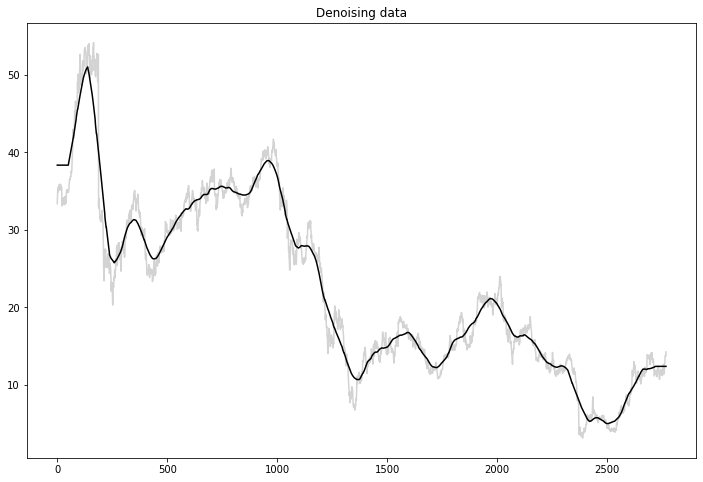

In [139]:
dfs = pd.read_csv("MRO.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [140]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [141]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "MRO", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6868 - accuracy: 0.5438 - val_loss: 0.7335 - val_accuracy: 0.3265
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5328 - accuracy: 0.7195 - val_loss: 0.7174 - val_accuracy: 0.7490
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3120 - accuracy: 0.8882 - val_loss: 0.2575 - val_accuracy: 0.9000
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2372 - accuracy: 0.9012 - val_loss: 1.1762 - val_accuracy: 0.5510
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2663 - accuracy: 0.8935 - val_loss: 0.3028 - val_accuracy: 0.8510
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 12ms/step - loss: 0.6102 - accuracy: 0.6467 - val_loss: 0.3305 - val_accuracy: 0.8673
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [142]:
Result_cross.to_csv('MRO_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1  recal
0          LSTM 0.05  MRO  0.686695  0.851020  0.814249    1.0
1           GRU 0.05  MRO  0.661157  0.832653  0.796020    1.0
2       XGBoost 0.05  MRO  0.675105  0.842857  0.806045    1.0
3        Logreg 0.05  MRO  0.592593  0.775510  0.744186    1.0
4           SVM 0.05  MRO  0.653061  0.826531  0.790123    1.0
5     LSTM beta 0.05  MRO  0.535865  0.759300  0.697802    1.0
6      GRU beta 0.05  MRO  0.661458  0.857768  0.796238    1.0
7  XGBoost beta 0.05  MRO  0.631841  0.838074  0.774390    1.0
8   logreg beta 0.05  MRO  0.579909  0.798687  0.734104    1.0
9      svm beta 0.05  MRO  0.596244  0.811816  0.747059    1.0

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_logreg_beta.csv')

###Purging

In [143]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "MRO", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.6936 - accuracy: 0.5503 - val_loss: 0.7534 - val_accuracy: 0.3265
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6285 - accuracy: 0.6154 - val_loss: 0.7087 - val_accuracy: 0.7061
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2749 - accuracy: 0.8959 - val_loss: 0.5863 - val_accuracy: 0.7551
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2413 - accuracy: 0.9041 - val_loss: 0.2978 - val_accuracy: 0.8816
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2348 - accuracy: 0.9053 - val_loss: 0.4546 - val_accuracy: 0.8347
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6025 - accuracy: 0.6533 - val_loss: 0.6122 - val_accuracy: 0.7204
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [144]:
Result_purging.to_csv('MRO_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1  recal
0          LSTM 0.05  MRO  0.663900  0.834694  0.798005    1.0
1           GRU 0.05  MRO  0.723982  0.875510  0.839895    1.0
2       XGBoost 0.05  MRO  0.675105  0.842857  0.806045    1.0
3        Logreg 0.05  MRO  0.592593  0.775510  0.744186    1.0
4           SVM 0.05  MRO  0.653061  0.826531  0.790123    1.0
5     LSTM beta 0.05  MRO  0.619512  0.829322  0.765060    1.0
6      GRU beta 0.05  MRO  0.604762  0.818381  0.753709    1.0
7  XGBoost beta 0.05  MRO  0.631841  0.838074  0.774390    1.0
8   logreg beta 0.05  MRO  0.579909  0.798687  0.734104    1.0
9      svm beta 0.05  MRO  0.596244  0.811816  0.747059    1.0

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('MRO_logreg_beta_p.csv')

## NKTR

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>   <LOW>   <CLOSE>   <VOL>
0     US1.NKTR     D  20101004       0  ...   14.85  14.350  12.99510  419270
1     US1.NKTR     D  20101005       0  ...   14.95  14.530  12.99510  441063
2     US1.NKTR     D  20101006       0  ...   15.15  14.800  12.99510  392593
3     US1.NKTR     D  20101007       0  ...   15.25  14.800  12.99510  236730
4     US1.NKTR     D  20101008       0  ...   15.83  14.840  12.99510  497674
...        ...   ...       ...     ...  ...     ...     ...       ...     ...
2762  US1.NKTR     D  20210927       0  ...   19.32  18.590  16.61105   15873
2763  US1.NKTR     D  20210928       0  ...   18.90  18.350  16.61105   15735
2764  US1.NKTR     D  20210929       0  ...   18.52  17.905  16.61105   22410
2765  US1.NKTR     D  20210930       0  ...   18.28  17.900  16.61105   28262
2766  US1.NKTR     D  20211001       0  ...   18.51  17.950  16.61105   34775

[2767 rows x 9 columns]

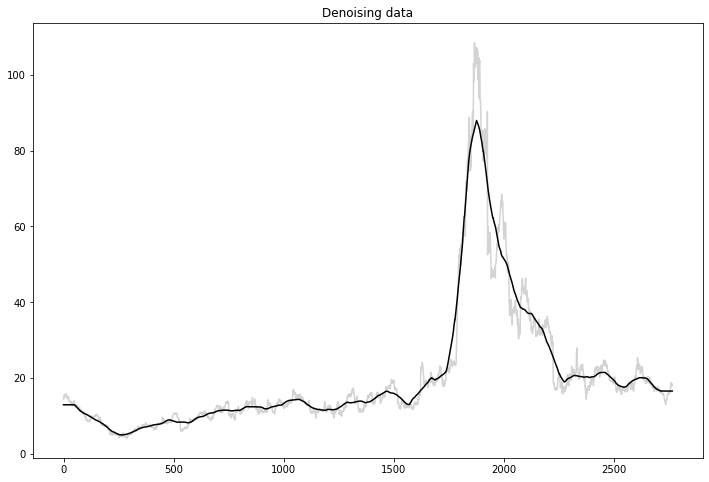

In [145]:
dfs = pd.read_csv("NKTR.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [146]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [147]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "NKTR", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.5915 - accuracy: 0.7272 - val_loss: 1.3726 - val_accuracy: 0.1878
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5759 - accuracy: 0.7355 - val_loss: 0.9732 - val_accuracy: 0.1878
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4431 - accuracy: 0.8154 - val_loss: 0.2757 - val_accuracy: 0.9204
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3511 - accuracy: 0.8580 - val_loss: 0.3538 - val_accuracy: 0.8980
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2966 - accuracy: 0.8799 - val_loss: 0.4250 - val_accuracy: 0.8184
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.5805 - accuracy: 0.7284 - val_loss: 1.1380 - val_accuracy: 0.1878
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [148]:
Result_cross.to_csv('NKTR_Result_cross.csv')
Result_cross

Model  Name      Perc       acc        f1     recal
0          LSTM 0.05  NKTR  0.508772  0.818367  0.661597  0.945652
1           GRU 0.05  NKTR  0.687500  0.910204  0.800000  0.956522
2       XGBoost 0.05  NKTR  0.735537  0.928571  0.835681  0.967391
3        Logreg 0.05  NKTR  0.514620  0.822449  0.669202  0.956522
4           SVM 0.05  NKTR  0.733333  0.926531  0.830189  0.956522
5     LSTM beta 0.05  NKTR  0.381356  0.809628  0.508475  0.762712
6      GRU beta 0.05  NKTR  0.689189  0.932166  0.766917  0.864407
7  XGBoost beta 0.05  NKTR  0.670455  0.936543  0.802721  1.000000
8   logreg beta 0.05  NKTR  0.528736  0.881838  0.630137  0.779661
9      svm beta 0.05  NKTR  0.666667  0.932166  0.783217  0.949153

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_logreg_beta.csv')

###Purging

In [149]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "NKTR", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.5979 - accuracy: 0.7320 - val_loss: 1.0111 - val_accuracy: 0.1878
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5315 - accuracy: 0.7580 - val_loss: 0.1422 - val_accuracy: 0.9735
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2981 - accuracy: 0.8882 - val_loss: 0.2461 - val_accuracy: 0.8918
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2924 - accuracy: 0.8846 - val_loss: 0.1138 - val_accuracy: 0.9714
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2866 - accuracy: 0.8864 - val_loss: 0.3585 - val_accuracy: 0.8429
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 12ms/step - loss: 0.5875 - accuracy: 0.7278 - val_loss: 0.9469 - val_accuracy: 0.1878
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [150]:
Result_purging.to_csv('NKTR_Result_purging.csv')
Result_purging

Model  Name      Perc       acc        f1     recal
0          LSTM 0.05  NKTR  0.547170  0.842857  0.693227  0.945652
1           GRU 0.05  NKTR  0.763158  0.934694  0.844660  0.945652
2       XGBoost 0.05  NKTR  0.735537  0.928571  0.835681  0.967391
3        Logreg 0.05  NKTR  0.514620  0.822449  0.669202  0.956522
4           SVM 0.05  NKTR  0.733333  0.926531  0.830189  0.956522
5     LSTM beta 0.05  NKTR  0.677966  0.916849  0.677966  0.677966
6      GRU beta 0.05  NKTR  0.750000  0.940919  0.780488  0.813559
7  XGBoost beta 0.05  NKTR  0.670455  0.936543  0.802721  1.000000
8   logreg beta 0.05  NKTR  0.528736  0.881838  0.630137  0.779661
9      svm beta 0.05  NKTR  0.666667  0.932166  0.783217  0.949153

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NKTR_logreg_beta_p.csv')

## NVDA

<TICKER> <PER>    <DATE>  <TIME>  ...   <HIGH>   <LOW>     <CLOSE>     <VOL>
0     US1.NVDA     D  20101004       0  ...   11.430   11.01   16.665122  18184874
1     US1.NVDA     D  20101005       0  ...   11.500   11.29   16.665122  18266877
2     US1.NVDA     D  20101006       0  ...   11.370   10.67   16.665122  25753399
3     US1.NVDA     D  20101007       0  ...   10.840   10.38   16.665122  18732301
4     US1.NVDA     D  20101008       0  ...   10.950   10.51   16.665122  16998198
...        ...   ...       ...     ...  ...      ...     ...         ...       ...
2762  US1.NVDA     D  20210927       0  ...  217.750  213.28  443.619600    625939
2763  US1.NVDA     D  20210928       0  ...  214.030  206.51  443.619600    835341
2764  US1.NVDA     D  20210929       0  ...  210.160  204.68  443.619600    606902
2765  US1.NVDA     D  20210930       0  ...  210.650  206.89  443.619600    537697
2766  US1.NVDA     D  20211001       0  ...  208.485  202.04  443.619600    657406

[2767 rows x 9 columns]

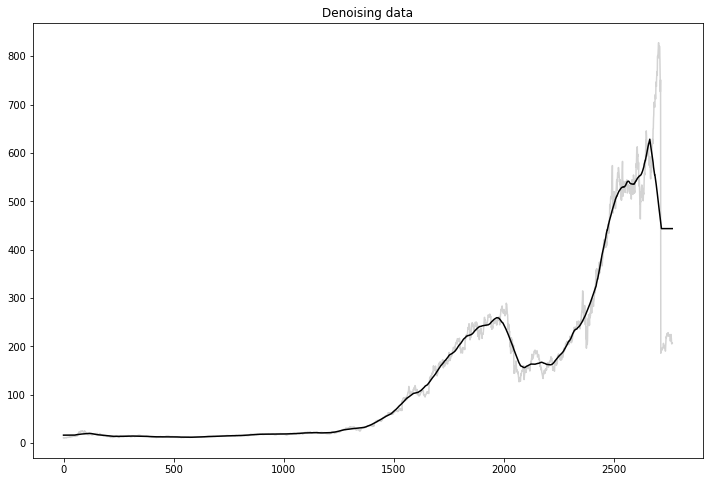

In [151]:
dfs = pd.read_csv("NVDA.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [152]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [153]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "NVDA", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.5579 - accuracy: 0.7728 - val_loss: 0.5708 - val_accuracy: 0.7408
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5220 - accuracy: 0.7793 - val_loss: 0.5746 - val_accuracy: 0.7408
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5477 - accuracy: 0.7734 - val_loss: 0.5705 - val_accuracy: 0.7408
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5424 - accuracy: 0.7734 - val_loss: 0.5695 - val_accuracy: 0.7408
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5363 - accuracy: 0.7734 - val_loss: 0.5677 - val_accuracy: 0.7408
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.5520 - accuracy: 0.7751 - val_loss: 0.5499 - val_accuracy: 0.7408
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [154]:
Result_cross.to_csv('NVDA_Result_cross.csv')
Result_cross

Model  Name      Perc       acc        f1     recal
0          LSTM 0.05  NVDA  0.740816  0.740816  0.851114  1.000000
1           GRU 0.05  NVDA  0.975309  0.887755  0.919942  0.870523
2       XGBoost 0.05  NVDA  0.978723  0.902041  0.930636  0.887052
3        Logreg 0.05  NVDA  0.930769  0.944898  0.964143  1.000000
4           SVM 0.05  NVDA  0.973607  0.918367  0.943182  0.914601
5     LSTM beta 0.05  NVDA  0.932432  0.838074  0.881789  0.836364
6      GRU beta 0.05  NVDA  0.936027  0.844639  0.886762  0.842424
7  XGBoost beta 0.05  NVDA  0.939210  0.910284  0.937785  0.936364
8   logreg beta 0.05  NVDA  0.928349  0.879650  0.915515  0.903030
9      svm beta 0.05  NVDA  0.863372  0.824945  0.881306  0.900000

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_logreg_beta.csv')

###Purging

In [155]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "NVDA", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.5498 - accuracy: 0.7680 - val_loss: 0.5853 - val_accuracy: 0.7408
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5429 - accuracy: 0.7734 - val_loss: 0.5728 - val_accuracy: 0.7408
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5367 - accuracy: 0.7734 - val_loss: 0.5698 - val_accuracy: 0.7408
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5587 - accuracy: 0.7509 - val_loss: 0.5723 - val_accuracy: 0.7408
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5430 - accuracy: 0.7734 - val_loss: 0.5730 - val_accuracy: 0.7408
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.5515 - accuracy: 0.7722 - val_loss: 0.5469 - val_accuracy: 0.7408
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [156]:
Result_purging.to_csv('NVDA_Result_purging.csv')
Result_purging

Model  Name      Perc       acc        f1     recal
0          LSTM 0.05  NVDA  0.740816  0.740816  0.851114  1.000000
1           GRU 0.05  NVDA  0.973988  0.928571  0.950635  0.928375
2       XGBoost 0.05  NVDA  0.978723  0.902041  0.930636  0.887052
3        Logreg 0.05  NVDA  0.930769  0.944898  0.964143  1.000000
4           SVM 0.05  NVDA  0.973607  0.918367  0.943182  0.914601
5     LSTM beta 0.05  NVDA  0.918089  0.814004  0.863563  0.815152
6      GRU beta 0.05  NVDA  0.944625  0.875274  0.910518  0.878788
7  XGBoost beta 0.05  NVDA  0.939210  0.910284  0.937785  0.936364
8   logreg beta 0.05  NVDA  0.928349  0.879650  0.915515  0.903030
9      svm beta 0.05  NVDA  0.863372  0.824945  0.881306  0.900000

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('NVDA_logreg_beta_p.csv')

## RHT

<TICKER> <PER>    <DATE>  <TIME>  ...    <HIGH>     <LOW>   <CLOSE>    <VOL>
0     US1.RHT     D  20101004       0  ...   41.2000   40.2400   40.0415  2037558
1     US1.RHT     D  20101005       0  ...   41.6050   40.8900   40.0415  3305240
2     US1.RHT     D  20101006       0  ...   41.5000   37.3300   40.0415  9840635
3     US1.RHT     D  20101007       0  ...   38.7499   37.5100   40.0415  5042146
4     US1.RHT     D  20101008       0  ...   38.8500   37.9500   40.0415  2255539
...       ...   ...       ...     ...  ...       ...       ...       ...      ...
2199  US1.RHT     D  20190701       0  ...  188.4194  187.5536  187.0370  1278873
2200  US1.RHT     D  20190702       0  ...  188.4000  187.9000  187.0370  1213064
2201  US1.RHT     D  20190703       0  ...  187.9500  187.4800  187.0370  1956137
2202  US1.RHT     D  20190705       0  ...  187.9300  187.5100  187.0370   671573
2203  US1.RHT     D  20190708       0  ...  187.8100  187.6000  187.0370   523715

[2204 rows x 9 columns]

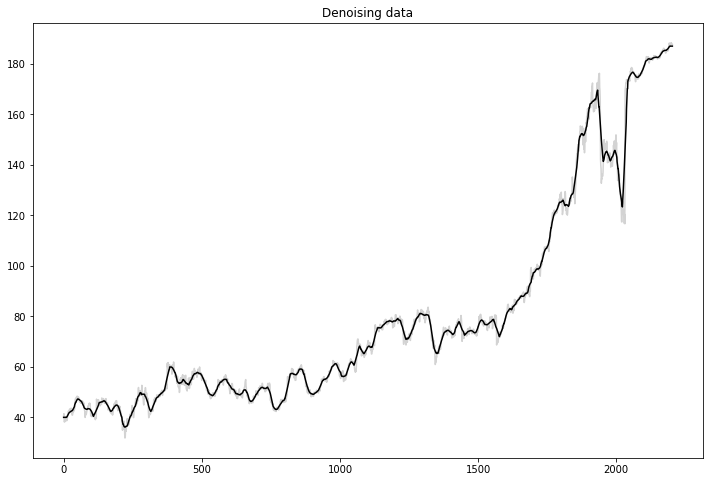

In [184]:
dfs = pd.read_csv("RHT.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>', k=20)
dfs

In [185]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2200)

### Cross

In [186]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1400, test_end=1800)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "RHT", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
81/81 [==============================] - 3s 15ms/step - loss: 0.6760 - accuracy: 0.6093 - val_loss: 0.5623 - val_accuracy: 0.8949
Epoch 2/5
81/81 [==============================] - 1s 10ms/step - loss: 0.5595 - accuracy: 0.7054 - val_loss: 0.2001 - val_accuracy: 0.9385
Epoch 3/5
81/81 [==============================] - 1s 11ms/step - loss: 0.4390 - accuracy: 0.8023 - val_loss: 0.3181 - val_accuracy: 0.8692
Epoch 4/5
81/81 [==============================] - 1s 11ms/step - loss: 0.4190 - accuracy: 0.8302 - val_loss: 0.2393 - val_accuracy: 0.9231
Epoch 5/5
81/81 [==============================] - 1s 10ms/step - loss: 0.3975 - accuracy: 0.8364 - val_loss: 0.2627 - val_accuracy: 0.9103
end training. 

start gru training...

Epoch 1/5
81/81 [==============================] - 2s 13ms/step - loss: 0.6621 - accuracy: 0.6295 - val_loss: 0.4287 - val_accuracy: 0.8949
Epoch 2/5
81/81 [==============================] - 1s 10ms/step - loss: 0.5010

In [187]:
Result_cross.to_csv('RHT_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  RHT  0.981595  0.910256  0.948148  0.916905
1           GRU 0.05  RHT  0.987730  0.920513  0.954074  0.922636
2       XGBoost 0.05  RHT  0.996835  0.910256  0.947368  0.902579
3        Logreg 0.05  RHT  0.976190  0.925641  0.957664  0.939828
4           SVM 0.05  RHT  0.993884  0.933333  0.961538  0.931232
5     LSTM beta 0.05  RHT  0.993464  0.929972  0.960506  0.929664
6      GRU beta 0.05  RHT  1.000000  0.890756  0.936585  0.880734
7  XGBoost beta 0.05  RHT  0.992308  0.801120  0.879046  0.788991
8   logreg beta 0.05  RHT  0.986971  0.921569  0.955836  0.926606
9      svm beta 0.05  RHT  1.000000  0.871148  0.924342  0.859327

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1443:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1443:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1443:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1443:1900].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_logreg_beta.csv')

###Purging

In [188]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1400, test_end=1800)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "RHT", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
81/81 [==============================] - 3s 17ms/step - loss: 0.6738 - accuracy: 0.6085 - val_loss: 0.5718 - val_accuracy: 0.8949
Epoch 2/5
81/81 [==============================] - 1s 11ms/step - loss: 0.6221 - accuracy: 0.6643 - val_loss: 0.2091 - val_accuracy: 0.9462
Epoch 3/5
81/81 [==============================] - 1s 11ms/step - loss: 0.5255 - accuracy: 0.7690 - val_loss: 0.3194 - val_accuracy: 0.8769
Epoch 4/5
81/81 [==============================] - 1s 11ms/step - loss: 0.4702 - accuracy: 0.7984 - val_loss: 0.3487 - val_accuracy: 0.8974
Epoch 5/5
81/81 [==============================] - 1s 10ms/step - loss: 0.4342 - accuracy: 0.8101 - val_loss: 0.4631 - val_accuracy: 0.7769
end training. 

start gru training...

Epoch 1/5
81/81 [==============================] - 3s 15ms/step - loss: 0.6437 - accuracy: 0.6465 - val_loss: 0.5126 - val_accuracy: 0.9667
Epoch 2/5
81/81 [==============================] - 1s 10ms/step - loss: 0.4242

In [189]:
Result_purging.to_csv('RHT_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  RHT  0.985185  0.776923  0.859451  0.762178
1           GRU 0.05  RHT  0.987988  0.938462  0.964809  0.942693
2       XGBoost 0.05  RHT  0.996835  0.910256  0.947368  0.902579
3        Logreg 0.05  RHT  0.976190  0.925641  0.957664  0.939828
4           SVM 0.05  RHT  0.993884  0.933333  0.961538  0.931232
5     LSTM beta 0.05  RHT  0.996622  0.907563  0.947030  0.902141
6      GRU beta 0.05  RHT  0.993464  0.929972  0.960506  0.929664
7  XGBoost beta 0.05  RHT  0.992308  0.801120  0.879046  0.788991
8   logreg beta 0.05  RHT  0.986971  0.921569  0.955836  0.926606
9      svm beta 0.05  RHT  1.000000  0.871148  0.924342  0.859327

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('RHT_logreg_beta_p.csv')

## STX

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>  <LOW>   <CLOSE>     <VOL>
0     US1.STX     D  20101004       0  ...   11.67  11.30  14.23465  10203081
1     US1.STX     D  20101005       0  ...   11.95  11.29  14.23465  18677214
2     US1.STX     D  20101006       0  ...   11.92  11.42  14.23465  20353875
3     US1.STX     D  20101007       0  ...   11.93  11.38  14.23465  15252399
4     US1.STX     D  20101008       0  ...   12.41  11.92  14.23465  19259065
...       ...   ...       ...     ...  ...     ...    ...       ...       ...
2763  US1.STX     D  20210927       0  ...   88.17  86.01  89.28725     36916
2764  US1.STX     D  20210928       0  ...   87.00  83.96  89.28725     65032
2765  US1.STX     D  20210929       0  ...   84.45  82.50  89.28725     36683
2766  US1.STX     D  20210930       0  ...   83.69  82.50  89.28725     40131
2767  US1.STX     D  20211001       0  ...   85.00  81.38  89.28725     43575

[2768 rows x 9 columns]

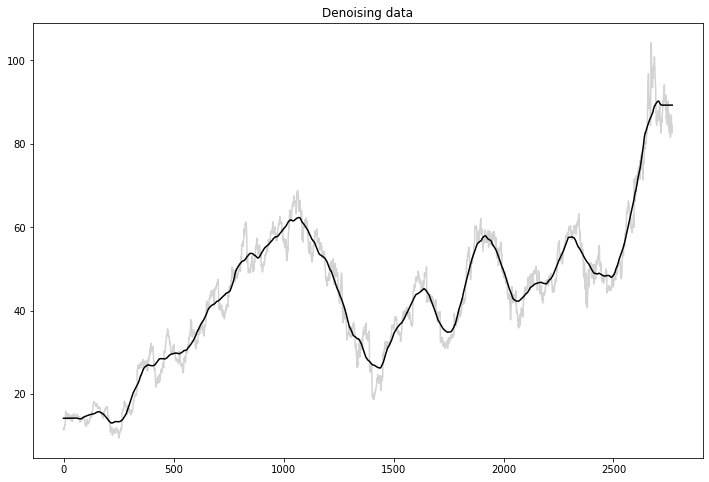

In [190]:
dfs = pd.read_csv("STX.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>')
dfs

In [191]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [192]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "STX", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6344 - accuracy: 0.6787 - val_loss: 0.6154 - val_accuracy: 0.6939
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.4741 - accuracy: 0.7799 - val_loss: 0.3362 - val_accuracy: 0.8551
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2393 - accuracy: 0.9107 - val_loss: 0.1240 - val_accuracy: 0.9408
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.1874 - accuracy: 0.9343 - val_loss: 0.1937 - val_accuracy: 0.9061
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.1814 - accuracy: 0.9402 - val_loss: 0.2555 - val_accuracy: 0.9041
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6134 - accuracy: 0.6911 - val_loss: 0.5284 - val_accuracy: 0.7449
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [193]:
Result_cross.to_csv('RMD_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  STX  0.878553  0.904082  0.935351  1.000000
1           GRU 0.05  STX  0.970674  0.961224  0.972100  0.973529
2       XGBoost 0.05  STX  0.949721  0.963265  0.974212  1.000000
3        Logreg 0.05  STX  0.878553  0.904082  0.935351  1.000000
4           SVM 0.05  STX  0.944444  0.959184  0.971429  1.000000
5     LSTM beta 0.05  STX  0.671772  0.671772  0.803665  1.000000
6      GRU beta 0.05  STX  0.964630  0.960613  0.970874  0.977199
7  XGBoost beta 0.05  STX  0.938650  0.954048  0.966825  0.996743
8   logreg beta 0.05  STX  0.912121  0.923414  0.945055  0.980456
9      svm beta 0.05  STX  0.924012  0.938731  0.955975  0.990228

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_logreg_beta.csv')

###Purging

In [194]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "STX", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6381 - accuracy: 0.6751 - val_loss: 0.6147 - val_accuracy: 0.6939
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5618 - accuracy: 0.7219 - val_loss: 0.1584 - val_accuracy: 0.9612
Epoch 3/5
106/106 [==============================] - 1s 11ms/step - loss: 0.2565 - accuracy: 0.9065 - val_loss: 0.1959 - val_accuracy: 0.9408
Epoch 4/5
106/106 [==============================] - 1s 12ms/step - loss: 0.2037 - accuracy: 0.9249 - val_loss: 0.1190 - val_accuracy: 0.9551
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.1943 - accuracy: 0.9302 - val_loss: 0.0987 - val_accuracy: 0.9653
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6114 - accuracy: 0.6864 - val_loss: 0.5132 - val_accuracy: 0.6939
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [195]:
Result_purging.to_csv('STX_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  STX  0.976401  0.965306  0.974963  0.973529
1           GRU 0.05  STX  0.959770  0.959184  0.970930  0.982353
2       XGBoost 0.05  STX  0.949721  0.963265  0.974212  1.000000
3        Logreg 0.05  STX  0.878553  0.904082  0.935351  1.000000
4           SVM 0.05  STX  0.944444  0.959184  0.971429  1.000000
5     LSTM beta 0.05  STX  0.890533  0.905908  0.933333  0.980456
6      GRU beta 0.05  STX  0.913690  0.936543  0.954899  1.000000
7  XGBoost beta 0.05  STX  0.938650  0.954048  0.966825  0.996743
8   logreg beta 0.05  STX  0.912121  0.923414  0.945055  0.980456
9      svm beta 0.05  STX  0.924012  0.938731  0.955975  0.990228

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('STX_logreg_beta_p.csv')

## SYY

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>   <LOW>   <CLOSE>    <VOL>
0     US1.SYY     D  20101004       0  ...  28.710  28.220  29.13865  3195008
1     US1.SYY     D  20101005       0  ...  28.830  28.400  29.13865  3718972
2     US1.SYY     D  20101006       0  ...  28.840  28.480  29.13865  2150778
3     US1.SYY     D  20101007       0  ...  28.680  28.430  29.13865  2226012
4     US1.SYY     D  20101008       0  ...  28.630  28.325  29.13865  2238435
...       ...   ...       ...     ...  ...     ...     ...       ...      ...
2764  US1.SYY     D  20210927       0  ...  82.520  80.870  77.08040   116348
2765  US1.SYY     D  20210928       0  ...  82.660  80.540  77.08040    79431
2766  US1.SYY     D  20210929       0  ...  81.760  80.240  77.08040    67594
2767  US1.SYY     D  20210930       0  ...  80.500  78.430  77.08040    98224
2768  US1.SYY     D  20211001       0  ...  81.415  78.900  77.08040    74171

[2769 rows x 9 columns]

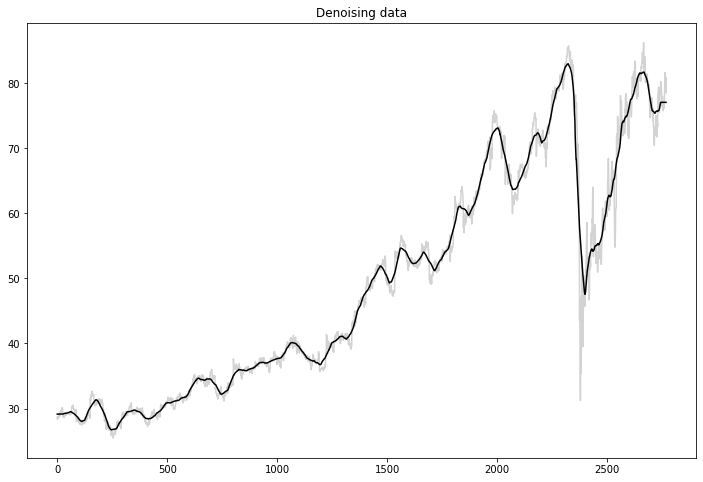

In [199]:
dfs = pd.read_csv("SYY.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>', k=50)
dfs

In [200]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [201]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "SYY", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6185 - accuracy: 0.7024 - val_loss: 0.4640 - val_accuracy: 0.8592
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6075 - accuracy: 0.7083 - val_loss: 0.4468 - val_accuracy: 0.8592
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6066 - accuracy: 0.7083 - val_loss: 0.5045 - val_accuracy: 0.8592
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6127 - accuracy: 0.7083 - val_loss: 0.4993 - val_accuracy: 0.8592
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6075 - accuracy: 0.7083 - val_loss: 0.4582 - val_accuracy: 0.8592
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6145 - accuracy: 0.7030 - val_loss: 0.4958 - val_accuracy: 0.8592
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [202]:
Result_cross.to_csv('SYY_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  SYY  0.859184  0.859184  0.924259  1.000000
1           GRU 0.05  SYY  0.986945  0.902041  0.940299  0.897862
2       XGBoost 0.05  SYY  0.991870  0.881633  0.926582  0.869359
3        Logreg 0.05  SYY  0.954649  0.959184  0.976798  1.000000
4           SVM 0.05  SYY  0.989529  0.904082  0.941469  0.897862
5     LSTM beta 0.05  SYY  0.969101  0.881838  0.927419  0.889175
6      GRU beta 0.05  SYY  0.980114  0.890591  0.932432  0.889175
7  XGBoost beta 0.05  SYY  0.976879  0.873085  0.920981  0.871134
8   logreg beta 0.05  SYY  0.961240  0.932166  0.960000  0.958763
9      svm beta 0.05  SYY  0.974648  0.888403  0.931359  0.891753

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_logreg_beta.csv')

###Purging

In [203]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "SYY", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 14ms/step - loss: 0.6162 - accuracy: 0.7065 - val_loss: 0.4916 - val_accuracy: 0.8592
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6144 - accuracy: 0.7083 - val_loss: 0.4514 - val_accuracy: 0.8592
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.6060 - accuracy: 0.7083 - val_loss: 0.4778 - val_accuracy: 0.8592
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5740 - accuracy: 0.7077 - val_loss: 0.4872 - val_accuracy: 0.8592
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5519 - accuracy: 0.7083 - val_loss: 0.3528 - val_accuracy: 0.9612
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.6132 - accuracy: 0.7065 - val_loss: 0.4685 - val_accuracy: 0.8592
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [204]:
Result_purging.to_csv('SYY_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  SYY  0.963134  0.961224  0.977778  0.992874
1           GRU 0.05  SYY  0.989583  0.908163  0.944099  0.902613
2       XGBoost 0.05  SYY  0.991870  0.881633  0.926582  0.869359
3        Logreg 0.05  SYY  0.954649  0.959184  0.976798  1.000000
4           SVM 0.05  SYY  0.989529  0.904082  0.941469  0.897862
5     LSTM beta 0.05  SYY  0.971787  0.809628  0.876945  0.798969
6      GRU beta 0.05  SYY  0.971279  0.940919  0.964981  0.958763
7  XGBoost beta 0.05  SYY  0.976879  0.873085  0.920981  0.871134
8   logreg beta 0.05  SYY  0.961240  0.932166  0.960000  0.958763
9      svm beta 0.05  SYY  0.974648  0.888403  0.931359  0.891753

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('SYY_logreg_beta_p.csv')

## TWTR

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>   <LOW>    <CLOSE>      <VOL>
0     US1.TWTR     D  20131107       0  ...  50.090  44.000  52.744774  103209765
1     US1.TWTR     D  20131108       0  ...  46.940  40.685  52.744774   26066094
2     US1.TWTR     D  20131111       0  ...  43.000  39.400  52.744774   15755276
3     US1.TWTR     D  20131112       0  ...  43.780  41.830  52.744774    5902473
4     US1.TWTR     D  20131113       0  ...  42.870  40.760  52.744774    7606967
...        ...   ...       ...     ...  ...     ...     ...        ...        ...
1984  US1.TWTR     D  20210927       0  ...  67.000  65.220  64.708600     331665
1985  US1.TWTR     D  20210928       0  ...  64.290  62.170  64.708600     332449
1986  US1.TWTR     D  20210929       0  ...  63.345  60.020  64.708600     285767
1987  US1.TWTR     D  20210930       0  ...  61.220  59.880  64.708600     307226
1988  US1.TWTR     D  20211001       0  ...  62.140  60.570  64.708600     291952

[1989 rows x 9 columns]

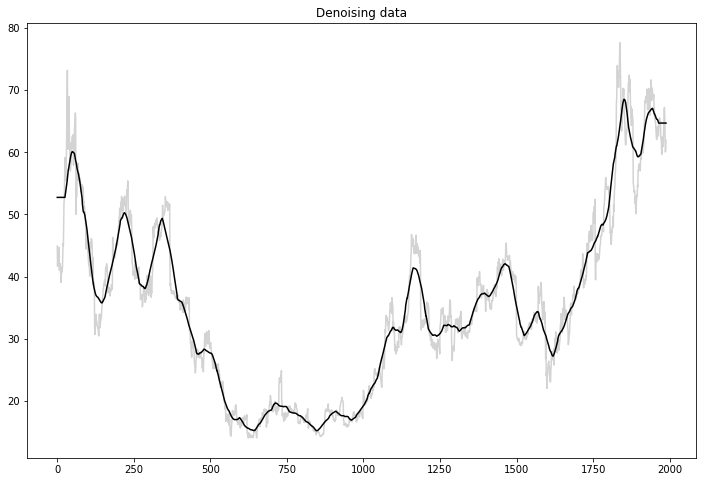

In [208]:
dfs = pd.read_csv("TWTR.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>', k=50)
dfs

In [209]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2000)

### Cross

In [210]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1400, test_end=1800)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "TWTR", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
81/81 [==============================] - 3s 21ms/step - loss: 0.6938 - accuracy: 0.5093 - val_loss: 0.7228 - val_accuracy: 0.2897
Epoch 2/5
81/81 [==============================] - 1s 11ms/step - loss: 0.5750 - accuracy: 0.7016 - val_loss: 0.2264 - val_accuracy: 0.9308
Epoch 3/5
81/81 [==============================] - 1s 11ms/step - loss: 0.5127 - accuracy: 0.7636 - val_loss: 0.4733 - val_accuracy: 0.8564
Epoch 4/5
81/81 [==============================] - 1s 10ms/step - loss: 0.3301 - accuracy: 0.8721 - val_loss: 0.2012 - val_accuracy: 0.9308
Epoch 5/5
81/81 [==============================] - 1s 11ms/step - loss: 0.3351 - accuracy: 0.8690 - val_loss: 0.2738 - val_accuracy: 0.9308
end training. 

start gru training...

Epoch 1/5
81/81 [==============================] - 2s 13ms/step - loss: 0.6689 - accuracy: 0.5860 - val_loss: 0.6440 - val_accuracy: 0.4718
Epoch 2/5
81/81 [==============================] - 1s 9ms/step - loss: 0.3466 

In [211]:
Result_cross.to_csv('SYY_Result_cross.csv')
Result_cross

Model  Name      Perc       acc        f1     recal
0          LSTM 0.05  TWTR  0.962963  0.930769  0.950640  0.938628
1           GRU 0.05  TWTR  0.981413  0.953846  0.967033  0.953069
2       XGBoost 0.05  TWTR  0.985294  0.966667  0.976321  0.967509
3        Logreg 0.05  TWTR  0.973978  0.943590  0.959707  0.945848
4           SVM 0.05  TWTR  0.985130  0.958974  0.970696  0.956679
5     LSTM beta 0.05  TWTR  0.947826  0.893557  0.919831  0.893443
6      GRU beta 0.05  TWTR  0.930041  0.901961  0.928131  0.926230
7  XGBoost beta 0.05  TWTR  0.947137  0.885154  0.912951  0.881148
8   logreg beta 0.05  TWTR  0.928870  0.890756  0.919255  0.909836
9      svm beta 0.05  TWTR  0.927350  0.876751  0.907950  0.889344

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_logreg_beta.csv')

###Purging

In [212]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1400, test_end=1800)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "TWTR", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
81/81 [==============================] - 3s 16ms/step - loss: 0.6942 - accuracy: 0.5357 - val_loss: 0.6974 - val_accuracy: 0.2897
Epoch 2/5
81/81 [==============================] - 1s 11ms/step - loss: 0.6132 - accuracy: 0.6736 - val_loss: 0.3166 - val_accuracy: 0.9154
Epoch 3/5
81/81 [==============================] - 1s 11ms/step - loss: 0.4605 - accuracy: 0.8054 - val_loss: 0.2226 - val_accuracy: 0.9282
Epoch 4/5
81/81 [==============================] - 1s 11ms/step - loss: 0.3715 - accuracy: 0.8519 - val_loss: 0.2457 - val_accuracy: 0.9103
Epoch 5/5
81/81 [==============================] - 1s 11ms/step - loss: 0.3565 - accuracy: 0.8566 - val_loss: 0.4179 - val_accuracy: 0.8282
end training. 

start gru training...

Epoch 1/5
81/81 [==============================] - 2s 14ms/step - loss: 0.6002 - accuracy: 0.6488 - val_loss: 0.2468 - val_accuracy: 0.9513
Epoch 2/5
81/81 [==============================] - 1s 10ms/step - loss: 0.2912

In [213]:
Result_purging.to_csv('TWTR_Result_purging.csv')
Result_purging

Model  Name      Perc       acc        f1     recal
0          LSTM 0.05  TWTR  1.000000  0.828205  0.862423  0.758123
1           GRU 0.05  TWTR  0.977941  0.956410  0.969035  0.960289
2       XGBoost 0.05  TWTR  0.985294  0.966667  0.976321  0.967509
3        Logreg 0.05  TWTR  0.973978  0.943590  0.959707  0.945848
4           SVM 0.05  TWTR  0.985130  0.958974  0.970696  0.956679
5     LSTM beta 0.05  TWTR  0.928870  0.890756  0.919255  0.909836
6      GRU beta 0.05  TWTR  0.995146  0.887955  0.911111  0.840164
7  XGBoost beta 0.05  TWTR  0.947137  0.885154  0.912951  0.881148
8   logreg beta 0.05  TWTR  0.928870  0.890756  0.919255  0.909836
9      svm beta 0.05  TWTR  0.927350  0.876751  0.907950  0.889344

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1410:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1443:1800].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('TWTR_logreg_beta_p.csv')

## WMT

<TICKER> <PER>    <DATE>  <TIME>  ...  <HIGH>    <LOW>    <CLOSE>    <VOL>
0     US1.WMT     D  20101004       0  ...   53.70   53.140   54.22745  6732639
1     US1.WMT     D  20101005       0  ...   54.25   53.830   54.22745  9078140
2     US1.WMT     D  20101006       0  ...   54.63   53.900   54.22745  9474898
3     US1.WMT     D  20101007       0  ...   54.82   54.040   54.22745  7316985
4     US1.WMT     D  20101008       0  ...   54.59   54.020   54.22745  8421572
...       ...   ...       ...     ...  ...     ...      ...        ...      ...
2762  US1.WMT     D  20210927       0  ...  143.51  141.850  145.54290   306424
2763  US1.WMT     D  20210928       0  ...  142.02  139.990  145.54290   313123
2764  US1.WMT     D  20210929       0  ...  141.82  140.330  145.54290   208623
2765  US1.WMT     D  20210930       0  ...  141.70  139.335  145.54290   295652
2766  US1.WMT     D  20211001       0  ...  139.58  135.940  145.54290   382464

[2767 rows x 9 columns]

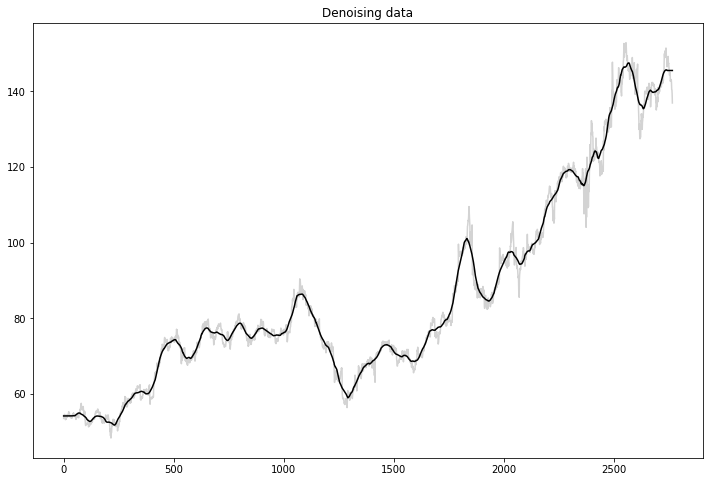

In [217]:
dfs = pd.read_csv("WMT.csv")
# dfs = dfs[::-1].reset_index()
# Denoise prices
dfs = denoise_data(dfs, '<CLOSE>', k=50)
dfs

In [218]:
visualize(dfs, '<CLOSE>', '<DATE>', 0.05, 100, 2300)

### Cross

In [219]:
col_name = '<CLOSE>'
threshholds = [.05]
Result_cross = pd.DataFrame()
Result_purging = pd.DataFrame()
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=False)
  historical.set_threshold(th=th)
  result = final_result(historical, "WMT", step_sizes=4, th=th)
  Result_cross = Result_cross.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.6015 - accuracy: 0.7290 - val_loss: 0.5382 - val_accuracy: 0.7959
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.5893 - accuracy: 0.7314 - val_loss: 0.5120 - val_accuracy: 0.7959
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5851 - accuracy: 0.7314 - val_loss: 0.5193 - val_accuracy: 0.7959
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4912 - accuracy: 0.7497 - val_loss: 0.3322 - val_accuracy: 0.8857
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3611 - accuracy: 0.8367 - val_loss: 0.2218 - val_accuracy: 0.9082
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.5911 - accuracy: 0.7284 - val_loss: 0.5106 - val_accuracy: 0.7959
Epoch 2/5
106/106 [==============================] - 1s 10ms/step 

In [220]:
Result_cross.to_csv('WMT_Result_cross.csv')
Result_cross

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  WMT  0.983193  0.908163  0.939759  0.900000
1           GRU 0.05  WMT  0.937337  0.887755  0.928849  0.920513
2       XGBoost 0.05  WMT  0.923858  0.885714  0.928571  0.933333
3        Logreg 0.05  WMT  0.864745  0.875510  0.927467  1.000000
4           SVM 0.05  WMT  0.917085  0.881633  0.926396  0.935897
5     LSTM beta 0.05  WMT  0.984802  0.894967  0.931034  0.882834
6      GRU beta 0.05  WMT  0.957507  0.903720  0.938889  0.920981
7  XGBoost beta 0.05  WMT  0.997085  0.943107  0.963380  0.931880
8   logreg beta 0.05  WMT  0.948509  0.921225  0.951087  0.953678
9      svm beta 0.05  WMT  0.956757  0.936543  0.960651  0.964578

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_lstm.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_gru.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_svm.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_xgboost.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_logreg.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_lstm_beta.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_gru_beta.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_svm_beta.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_xgboost_beta.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_logreg_beta.csv')

###Purging

In [221]:
for th in threshholds:
  print('Threshhold = ', th)
  true_label = labeling(dfs[col_name], th)
  dfs = dfs.assign(true_labels=pd.Series(true_label).values)

  historical = Train_data(dfs[col_name], train_start=100, train_end=1800, test_end=2300)
  historical.K_fold_purged(num_split=10, num_test=2, time_gaps=10, purging=True, emb=10)
  historical.set_threshold(th=th)
  result = final_result(historical, "WMT", step_sizes=4, th= th)
  Result_purging = Result_purging.append(result)

Threshhold =  0.05
start lstm training...

Epoch 1/5
106/106 [==============================] - 3s 15ms/step - loss: 0.5983 - accuracy: 0.7272 - val_loss: 0.5056 - val_accuracy: 0.7959
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5930 - accuracy: 0.7314 - val_loss: 0.5253 - val_accuracy: 0.7959
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5841 - accuracy: 0.7314 - val_loss: 0.5212 - val_accuracy: 0.7959
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5297 - accuracy: 0.7533 - val_loss: 0.3665 - val_accuracy: 0.7959
Epoch 5/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4227 - accuracy: 0.8018 - val_loss: 0.2481 - val_accuracy: 0.8898
end training. 

start gru training...

Epoch 1/5
106/106 [==============================] - 3s 13ms/step - loss: 0.5905 - accuracy: 0.7314 - val_loss: 0.5015 - val_accuracy: 0.7959
Epoch 2/5
106/106 [==============================] - 1s 9ms/step -

In [222]:
Result_purging.to_csv('WMT_Result_purging.csv')
Result_purging

Model Name      Perc       acc        f1     recal
0          LSTM 0.05  WMT  0.894366  0.889796  0.933824  0.976923
1           GRU 0.05  WMT  0.949602  0.895918  0.933507  0.917949
2       XGBoost 0.05  WMT  0.923858  0.885714  0.928571  0.933333
3        Logreg 0.05  WMT  0.864745  0.875510  0.927467  1.000000
4           SVM 0.05  WMT  0.917085  0.881633  0.926396  0.935897
5     LSTM beta 0.05  WMT  0.972393  0.870897  0.914863  0.863760
6      GRU beta 0.05  WMT  0.968023  0.901532  0.936709  0.907357
7  XGBoost beta 0.05  WMT  0.997085  0.943107  0.963380  0.931880
8   logreg beta 0.05  WMT  0.948509  0.921225  0.951087  0.953678
9      svm beta 0.05  WMT  0.956757  0.936543  0.960651  0.964578

In [ ]:
# Save predictions 


# 11 days

# LSTM
pred = historical.LSTM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_lstm_p.csv')
# GRU
pred = historical.GRU_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_gru_p.csv')
# SVM
pred = historical.SVM_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_svm_p.csv')
# XGBoost
pred = historical.XGboost_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_xgboost_p.csv')
# Logreg
pred = historical.Logreg_predict
new_dfs = dfs[1810:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_logreg_p.csv')


# 44 days

# LSTM
pred = historical.LSTM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_lstm_beta_p.csv')
# GRU
pred = historical.GRU_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_gru_beta_p.csv')
# SVM
pred = historical.SVM_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_svm_beta_p.csv')
# XGBoost
pred = historical.XGboost_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_xgboost_beta_p.csv')
# Logreg
pred = historical.Logreg_beta_predict
new_dfs = dfs[1843:2300].assign(labels=pd.Series(pred).values)
new_dfs.to_csv('WMT_logreg_beta_p.csv')